##Получение данных

###Получение данных с Московской биржи
На сайте Московской биржи есть API, который позволяет скачать биржевую информацию. С информацией по этому API можно ознакомиться https://fs.moex.com/files/6523. Код представленный ниже загружает всю доступную (бесплатно) информацию о старейшей акции "Газпром нефти" (тикер SIBN на Moex). С недавнего времени доступ к этому API может быть ограничен с территории недружественных государств, следовательно с Colab может давать ошибку "urlopen error [Errno 110] Connection timed out". По этой причине данные были получены и загружены в csv-файл, который в свою очередь был загружен на гугл-диск.

In [ ]:
#Подключение необходимых библиотек
import pandas as pd
import numpy as np

In [ ]:
# Получение дневных данных по акции Гапромнефти
url = 'http://iss.moex.com/iss/history/engines/stock/markets/shares/securities/'
url += 'SIBN.json?start='
filename = '/content/drive/MyDrive/edu/sibn.csv'
start = 0
total = 1
size = 0
while start < total:
  res = pd.read_json(url + str(start))
  jhist = res['history']
  jdata = jhist['data']
  if start == 0:
    jcols = jhist['columns']
    df = pd.DataFrame(jdata, columns=jcols)
    jcur = res['history.cursor']
    jcur = jcur['data'][0]
    total = jcur[1]
    size = jcur[2]
    df.to_csv(filename, index=False)
  else:
    df = pd.DataFrame(jdata, columns=jcols)
    df.to_csv(filename, header=False, mode='a', index=False)
  start += size

###Подготовка данных

In [ ]:
# Загрузим csv и посмотрим его содержание
df = pd.read_csv(filename, parse_dates=['TRADEDATE'])
df.head()

,BOARDID,TRADEDATE,SHORTNAME,SECID,NUMTRADES,VALUE,OPEN,LOW,HIGH,LEGALCLOSEPRICE,...,CLOSE,VOLUME,MARKETPRICE2,MARKETPRICE3,ADMITTEDQUOTE,MP2VALTRD,MARKETPRICE3TRADESVALUE,ADMITTEDVALUE,WAVAL,TRADINGSESSION
0,EQBR,2003-07-10,Газпрнефть,SIBN,237,29036838.0,75.68,72.00,75.68,NaN,...,73.80,396000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,EQBR,2003-07-11,Газпрнефть,SIBN,232,33913177.0,72.85,69.52,73.35,NaN,...,71.20,472900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,EQBR,2003-07-14,Газпрнефть,SIBN,126,11025628.0,71.20,70.41,73.49,NaN,...,73.00,153100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,EQBR,2003-07-15,Газпрнефть,SIBN,150,13575563.0,77.74,50.00,77.74,NaN,...,72.50,187900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,EQBR,2003-07-16,Газпрнефть,SIBN,205,15924460.0,74.00,65.01,74.00,NaN,...,65.01,233800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


Мы видим множество колонок, но нам нужны только некоторые из них. Например, SHORTNAME содержит короткое название финансового актива, а SECID тикер (текстовую метку) на бирже, если мы анализируем только один актив, то эти значения будут одинаковы во всех строках, поэтому нам они не нужны. Проще перечислить колонки, которые будут нужны:
*   BOARDID - режим торгов (чуть позже мы воспользуемся этим полем, чтобы убрать лишние строки по одной дате;
*   TRADEDATE - дата;
*   OPEN - цена открытия;
*   LOW - самая нижняя цена периода;
*   HIGH - максимальная цена периода;
*   CLOSE - цена закрытия (целевое значение);
*   VOLUME - объем проторгованных контрактов.



In [ ]:
df = df[['TRADEDATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'BOARDID']]

Проверим уникальность даты, имеется ли только одна запись за один день

In [ ]:
df.TRADEDATE.is_unique

False

In [ ]:
# Посмотрим какие даты имеют больше одной строки
dt_count = df.TRADEDATE.value_counts()
dt_double = dt_count[dt_count > 1].index.tolist()
df[df.TRADEDATE.isin(dt_double)].head(10)

,TRADEDATE,OPEN,HIGH,LOW,CLOSE,VOLUME,BOARDID
479,2005-06-16,88.01,88.45,86.88,87.40,826000,EQNL
480,2005-06-16,NaN,NaN,NaN,NaN,0,SMAL
482,2005-06-20,88.94,89.90,88.63,88.98,817000,EQNL
483,2005-06-20,67.50,67.50,67.50,67.50,80,SMAL
485,2005-06-22,87.88,90.20,87.88,89.10,1769000,EQNL
486,2005-06-22,67.50,67.50,67.50,67.50,56,SMAL
490,2005-06-28,90.50,92.20,89.82,91.73,2129200,EQNL
491,2005-06-28,91.40,91.40,91.40,91.40,15,SMAL
493,2005-06-30,92.99,95.17,92.90,94.95,2976900,EQNL
494,2005-06-30,91.00,91.00,91.00,91.00,27,SMAL


Для начала удалим записи, в которых объем торгов нулевой. А также удалим записи с режимом торгов SMAL, а потом опять посмотрим дубли

In [ ]:
df.drop(index=df[df.VOLUME == 0].index, inplace=True)
df.drop(index=df[df.BOARDID == 'SMAL'].index, inplace=True)
dt_count = df.TRADEDATE.value_counts()
dt_double = dt_count[dt_count > 1].index.tolist()
df[df.TRADEDATE.isin(dt_double)].head(10)

,TRADEDATE,OPEN,HIGH,LOW,CLOSE,VOLUME,BOARDID
3824,2013-08-22,125.91,128.80,124.88,128.61,1081740,EQNE
3826,2013-08-22,127.00,127.00,127.00,127.00,260,TQNE
3832,2013-08-26,129.98,131.95,127.86,129.56,454950,EQNE
3834,2013-08-26,129.00,129.00,129.00,129.00,30,TQNE
3847,2013-08-30,134.39,136.60,130.96,135.57,744170,EQNE
3849,2013-08-30,133.25,138.00,133.25,138.00,210,TQNE
8444,2022-03-30,416.30,416.30,416.30,416.30,8720,SPEQ
8445,2022-03-30,399.60,427.00,398.00,422.00,333044,TQBR
8497,2022-06-17,438.50,438.50,438.50,438.50,2980,SPEQ
8498,2022-06-17,443.40,449.85,440.00,444.00,428928,TQBR


Еще удалим записи с режимом SPEQ, а вот TQNE будем удалять только по дням.

In [ ]:
df.drop(index=df[df.BOARDID == 'SPEQ'].index, inplace=True)
df.drop(index=df[(df.BOARDID == 'TQNE') & (df.TRADEDATE == '2013-08-22')].index, 
         inplace=True)
df.drop(index=df[(df.BOARDID == 'TQNE') & (df.TRADEDATE == '2013-08-26')].index, 
         inplace=True)
df.drop(index=df[(df.BOARDID == 'TQNE') & (df.TRADEDATE == '2013-08-30')].index, 
         inplace=True)
df.TRADEDATE.is_unique

True

Продолжим разведывательный анализ, проверим пустые значения

In [ ]:
df.isna().sum()

TRADEDATE    0
OPEN         0
HIGH         0
LOW          0
CLOSE        0
VOLUME       0
BOARDID      0
dtype: int64

In [ ]:
# Данные вычищены. Удалим режим торгов, так как он нам больше не нужен. И сохраним очищенный набор данных
df = df.drop('BOARDID', axis=1)
df.to_csv('/content/drive/MyDrive/edu/sibn_clear.csv', index=False)

Данные получены, отобраны нужные поля, очищены строки с дублирующими датами и пустыми значениями. Данные готовы к анализу

###Парсинг данных с Московской биржи
Попробуем получить данные торгов поминутно, для этого изменим программу. Этот вариант также описан в документе https://fs.moex.com/files/6523. С недавнего времени доступ к этому API может быть ограничен с территории недружественных государств, следовательно с Colab может давать ошибку "urlopen error [Errno 110] Connection timed out". На данный момент код работает прямо в колабе. Данный блокнот можно запускать с отключенным графическим ускорителем.

In [ ]:
url = 'http://iss.moex.com/iss/engines/stock/markets/shares/securities/SIBN/'
url1 = 'candles.json?interval=1&start='
filename = '/content/drive/MyDrive/edu/sibn_minute.csv'
start = 0
size = 500
while size == 500:
  res = pd.read_json(f'{url}{url1}{str(start)}')
  jcandles = res['candles']
  jdata = jcandles['data']
  if start == 0:
    jcols = jcandles['columns']
    df = pd.DataFrame(jdata, columns=jcols)
    df.to_csv(filename, index=False)
  else:
    df = pd.DataFrame(jdata, columns=jcols)
    size = len(df)
    df.to_csv(filename, header=False, mode='a', index=False)
  start += size

In [ ]:
# посмотрим начало файла
!head /content/drive/MyDrive/edu/sibn_minute.csv

open,close,high,low,value,volume,begin,end
148.07,148.07,148.07,148.07,2961.4,20,2014-06-09 10:23:00,2014-06-09 10:23:59
148.94,148.94,148.94,148.94,84895.8,570,2014-06-09 10:25:00,2014-06-09 10:25:59
148.94,148.94,148.94,148.94,7447.0,50,2014-06-09 10:27:00,2014-06-09 10:27:59
148.96,148.96,148.96,148.96,4468.8,30,2014-06-09 10:41:00,2014-06-09 10:41:59
148.94,148.94,148.94,148.94,1489.4,10,2014-06-09 10:43:00,2014-06-09 10:43:59
148.3,148.3,148.3,148.3,14830.0,100,2014-06-09 10:52:00,2014-06-09 10:52:59
148.4,148.4,148.4,148.4,14840.0,100,2014-06-09 10:55:00,2014-06-09 10:55:59
148.5,148.39,148.5,148.39,17817.8,120,2014-06-09 10:57:00,2014-06-09 10:57:59
148.47,148.47,148.47,148.47,29694.0,200,2014-06-09 10:59:00,2014-06-09 10:59:59


###Подготовка данных

In [ ]:
# Загрузим csv и посмотрим его содержание в виде таблицы
# Из предыдущей ячейки мы знаем, что begin и end надо парсить как date
df = pd.read_csv(filename, parse_dates=['begin', 'end'])
df.head()

,open,close,high,low,value,volume,begin,end
0,148.07,148.07,148.07,148.07,2961.4,20,2014-06-09 10:23:00,2014-06-09 10:23:59
1,148.94,148.94,148.94,148.94,84895.8,570,2014-06-09 10:25:00,2014-06-09 10:25:59
2,148.94,148.94,148.94,148.94,7447.0,50,2014-06-09 10:27:00,2014-06-09 10:27:59
3,148.96,148.96,148.96,148.96,4468.8,30,2014-06-09 10:41:00,2014-06-09 10:41:59
4,148.94,148.94,148.94,148.94,1489.4,10,2014-06-09 10:43:00,2014-06-09 10:43:59


Проверим уникальность даты в поле begin

In [ ]:
df.begin.is_unique

True

In [ ]:
# так как это поле содержит уникальные записи оно может стать индексом
df1 = df.groupby('begin').first()
df1.tail()

,open,close,high,low,value,volume,end
begin,,,,,,,
2022-07-22 18:45:00,364.0,364.0,364.0,364.0,277004.0,761,2022-07-22 18:45:59
2022-07-22 18:46:00,364.0,364.0,364.0,364.0,346164.0,951,2022-07-22 18:46:59
2022-07-22 18:47:00,364.0,364.0,364.0,364.0,9100.0,25,2022-07-22 18:47:59
2022-07-22 18:48:00,364.0,364.0,364.0,364.0,72800.0,200,2022-07-22 18:48:59
2022-07-22 18:49:00,364.0,364.0,364.0,364.0,14924.0,41,2022-07-22 18:49:59


In [ ]:
# избавимся от лишних полей value и end
# первое отражает объем сделок в рублях
# второе - окончание периода
df = df1.drop(columns=['value', 'end'])
# получим информацию по таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 824763 entries, 2011-12-15 10:00:00 to 2022-07-22 18:49:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    824763 non-null  float64
 1   close   824763 non-null  float64
 2   high    824763 non-null  float64
 3   low     824763 non-null  float64
 4   volume  824763 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 37.8 MB


Проверим пустые и нулевые значения

In [ ]:
df[df.volume == 0]

,open,close,high,low,volume
begin,,,,,


In [ ]:
df.isna().sum()

open      0
close     0
high      0
low       0
volume    0
dtype: int64

In [ ]:
# Данные вычищены. Сохраним очищенный набор данных
df.to_csv(filename)

Данные получены, отобраны нужные поля, очищены строки с дублирующими датами и пустыми значениями. Данные готовы к анализу

##Выбор модели

###Базовая модель

In [ ]:
# Загружаем необходимые библиотеки
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Загружаем датасет
df = pd.read_csv('/content/drive/MyDrive/edu/sibn_clear.csv', 
                 index_col='TRADEDATE', parse_dates=['TRADEDATE'])
# В качестве выходных данных будем использовать поля HIGH и LOW
y_data = df[['HIGH', 'LOW']].to_numpy('float')
y_data = y_data[1:]
# Весь датасет в качестве входных
x_data = df[:-1].to_numpy('float')
# размерность данных
print(x_data.shape, y_data.shape)

(4733, 5) (4733, 2)


In [ ]:
# Масштабируем данные
x_scaler = MinMaxScaler()
x_train = x_scaler.fit_transform(x_data)
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_data)

In [ ]:
# Полносвязная сеть
model = Sequential()
model.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1], activation='linear'))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mse'])
history = model.fit(x_train, y_train, batch_size=32, epochs=16, 
                    validation_split=0.1)

Epoch 1/16
134/134 [==============================] - 3s 5ms/step - loss: 0.0765 - mse: 0.0174 - val_loss: 0.0485 - val_mse: 0.0029
Epoch 2/16
134/134 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 7.2684e-05 - val_loss: 0.0116 - val_mse: 3.9215e-04
Epoch 3/16
134/134 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 5.3088e-05 - val_loss: 0.0102 - val_mse: 3.7773e-04
Epoch 4/16
134/134 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 5.1694e-05 - val_loss: 0.0108 - val_mse: 4.0202e-04
Epoch 5/16
134/134 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 5.0498e-05 - val_loss: 0.0099 - val_mse: 3.5492e-04
Epoch 6/16
134/134 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 5.0001e-05 - val_loss: 0.0098 - val_mse: 3.4272e-04
Epoch 7/16
134/134 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 4.9119e-05 - val_loss: 0.0097 - val_mse: 3.5410e-04
Epoch 8/16
134/134 [========

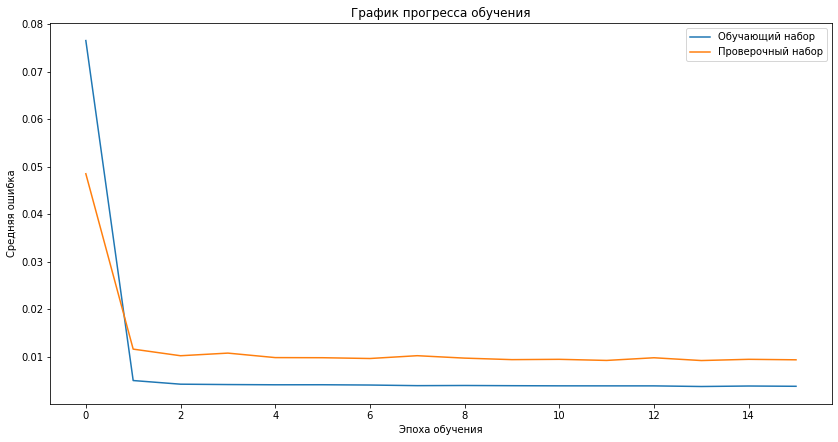

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Обучающий набор')
plt.plot(history.history['val_loss'], label='Проверочный набор')
plt.title('График прогресса обучения')
# Указание показывать только целые метки шкалы оси x
fig.gca().xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
def make_finplot(df):
  '''Функция рисует график аналогично mplfinance, используя matplotlib.pyplot.
  В качестве единственного входящего параметра должен использоваться 
  DataFrame pandas, в котором индексом является временной ряд, 
  а четыре цены должны следовать в следующем порядке: открытие, максимум,
  минимум, закрытие
  Функция возвращает временной вектор в строковом формате'''
  strdt = df.index.astype('str')
  # Временной ряд переводим в текстовый формат, чтобы устранить неторговые 
  # промежутки, например, выходные дни
  spans = (df.iloc[:, 1] - df.iloc[:, 2]) / 2
  center = (df.iloc[:, 1] + df.iloc[:, 2]) / 2
  plt.errorbar(strdt, center, spans, ls='none', ecolor='k')
  # Рисуем вертикальные линии от минимума до максимума
  plt.scatter(strdt, df.iloc[:, 3], marker=1, s=10, color='k')
  # Рисуем засечку закрытия
  plt.scatter(strdt, df.iloc[:, 0], marker=0, s=10, color='k')
  # Рисуем засечку открытия
  plt.xticks(rotation=90)
  # Поворачиваем подписи на 90 градусов
  return strdt

def correlate(a, b):
  '''Функция расчета корреляционного коэффициента Пирсона для двух рядов'''
  return np.corrcoef(a, b)[0, 1]

def plot_autocorr(y_pred, y_true, count_step):
  '''Функция рисования автокорреляции'''
  y_len = y_true.shape[0]
  steps = range(count_step + 1)
  plt.figure(figsize=(14, 7))
  cross_corr = []
  auto_corr = []
  for step in steps:
    # Вычисление коэффициентов корреляции базового ряда и предсказания 
    # с разным смещением
    cross_corr += [correlate(y_true[:y_len - step, 0], y_pred[step:, 0])]
    # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
    auto_corr += [correlate(y_true[:y_len - step, 0], y_true[step:, 0])]
  plt.plot(cross_corr, label='Прогноз')
  plt.plot(auto_corr, label='Факт')
  plt.xlabel('Шаги смещения')
  plt.ylabel('Коэффициент корреляции')
  plt.legend()
  plt.show()

def plot_train(history):
  '''Процедура рисования графика обучения'''
  plt.figure(figsize=(14, 7))
  plt.plot(history.history['loss'], label='Обучающий набор')
  plt.plot(history.history['val_loss'], label='Проверочный набор')
  plt.title('График прогресса обучения')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

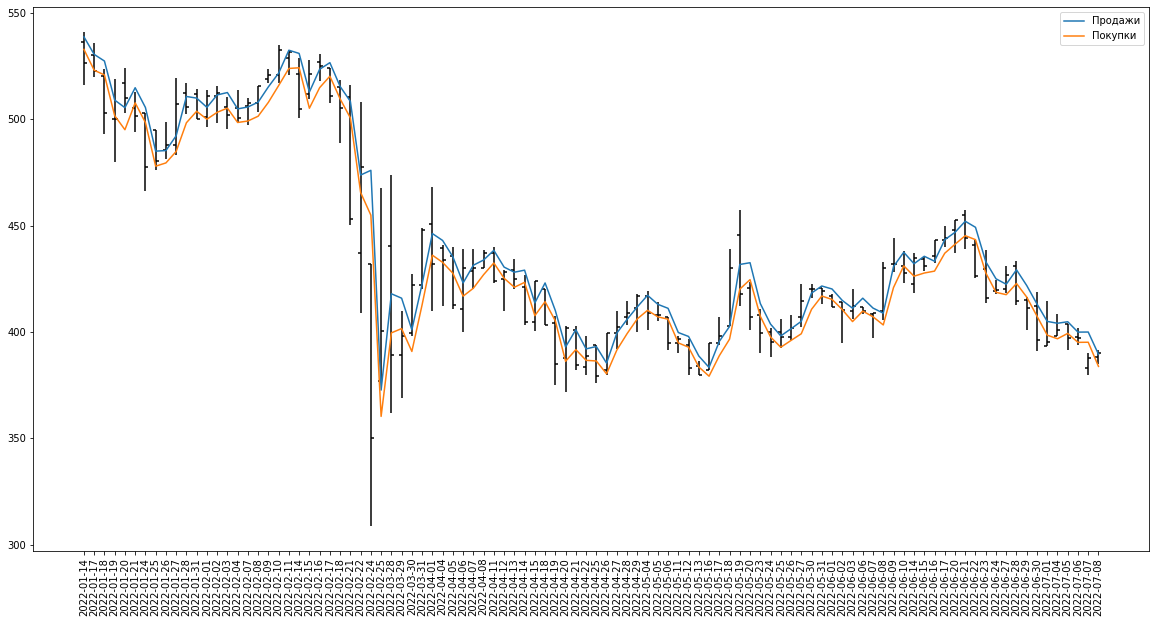

In [ ]:
# Получим результаты и визуализируем их
sep = int(len(df) * 0.9) + 2
y_pred = y_scaler.inverse_transform(model.predict(x_train[sep:], verbose=0))
test_df = df[sep + 1:]
y_true = test_df[['HIGH', 'LOW']].to_numpy()
plt.figure(figsize=(20, 10))
dtstr = make_finplot(test_df[-100:])
plt.plot(dtstr, y_pred[-100:, 0], label='Продажи')
plt.plot(dtstr, y_pred[-100:, 1], label='Покупки')
plt.legend()
plt.show()

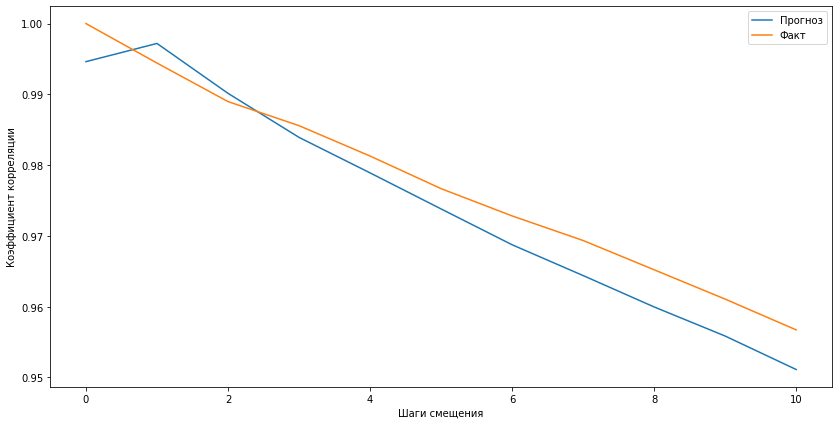

In [ ]:
plot_autocorr(y_pred, y_true, 10)

In [ ]:
# Получаем ошибку модели
low_pred = np.round(y_pred[:, 1], 2)
low_true = y_true[:, 1]
maelow = round(abs(low_pred - low_true).mean(), 2)
print('Средняя ошибка входа', maelow, 'руб., относительная ошибка', 
      round(maelow / low_true.mean() * 100, 2), '%')
high_pred = np.round(y_pred[:, 0], 2)
high_true = y_true[:, 0]
maehigh = round(abs(high_pred - high_true).mean(), 2)
print('Средняя ошибка выхода', maehigh, 'руб., относительная ошибка', 
      round(maehigh / high_true.mean() * 100, 2), '%')

Средняя ошибка входа 4.92 руб., относительная ошибка 1.25 %
Средняя ошибка выхода 4.81 руб., относительная ошибка 1.18 %


###Моделирование покупок и продаж

In [ ]:
# Логическая проверка заключается в том, что если вход будет ниже, 
# чем нижнее значение, то позиция не откроется
# Построим карту открытия позиции
op = 1 * (low_true <= low_pred) * (high_true >= low_pred)
len_test = len(op)
print('Процент открытых позиций', round(sum(op) * 100 / len_test, 2), '%')
fail = sum(1 * (high_true < high_pred))
print('Процент закрытых позиций в конце дня', round(fail * 100 / len_test,
                                                    2), '%')
# По карте составим цены открытия позиций
price_op = op * low_pred
# Цены закрытия позиции требуют цены закрытия
ccur = test_df.CLOSE.to_numpy()
# Цена закрытия зависит от открытия позиции и второй логической проверки
price_cp = op * (high_pred * (high_true >= high_pred) + ccur * \
                       (high_true < high_pred))
profit = price_cp - price_op
print('Доход составит', round(sum(profit), 2), 'рублей')

Процент открытых позиций 50.11 %
Процент закрытых позиций в конце дня 32.91 %
Доход составит 423.09 рублей


In [ ]:
# Сравним заработанную сумму с доходом, если бы мы в начале тестового периода
# купили акции, а в конце продали
round(ccur[-1] - ccur[0], 2)

69.5

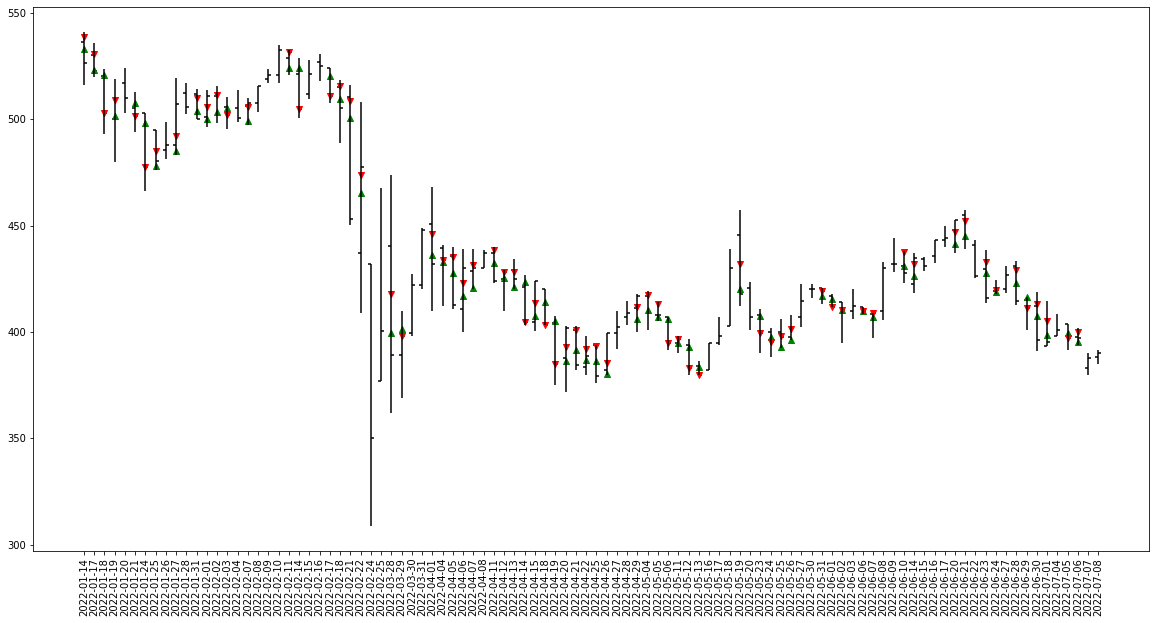

In [ ]:
# Визуализируем наши покупки и продажи
plt.figure(figsize=(20, 10))
dtstr = make_finplot(test_df[-100:])
price_op = price_op[-100:]
price_cp = price_cp[-100:]
plt.scatter(dtstr[price_op > 0], price_op[price_op > 0], marker='^', color='g')
plt.scatter(dtstr[price_cp > 0], price_cp[price_cp > 0], marker='v', color='r')
plt.show()

Получилась очень хорошая модель. Возьмем её в качестве базовой. Попробуем получить лучший результат.

###Добавление входных данных

In [ ]:
# Загружаем датасет
df = pd.read_csv('/content/drive/MyDrive/edu/sibn_clear.csv', 
                 index_col='TRADEDATE', parse_dates=['TRADEDATE'])
# В качестве выходных данных будем использовать поля HIGH и LOW
y_data = df[['HIGH', 'LOW']].to_numpy('float')
y_data = y_data[1:]
# добавим еще параметров
df['buy'] = df.OPEN - df.LOW
df['volatility'] = df.HIGH - df.LOW
df['result'] = df.CLOSE - df.OPEN
df['sell'] = df.HIGH - df.CLOSE
df['up'] = df.HIGH - df.OPEN
df['voldif']= df.VOLUME.diff()
df['cldif'] = df.CLOSE.diff()
df['hdif'] = df.HIGH.diff()
df['ldif'] = df.LOW.diff()
# Из-за смещения получим пустое значение.
# Заменим это пустое значение на 0
df.voldif.fillna(0, inplace=True)
df.cldif.fillna(0, inplace=True)
df.hdif.fillna(0, inplace=True)
df.ldif.fillna(0, inplace=True)
# Весь датасет в качестве входных
x_data = df[:-1].to_numpy('float')
# размерность данных
print(x_data.shape, y_data.shape)

(4733, 14) (4733, 2)


In [ ]:
# Масштабируем данные
x_scaler = MinMaxScaler()
x_train = x_scaler.fit_transform(x_data)
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_data)

In [ ]:
# Полносвязная сеть
model = Sequential()
model.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1], activation='linear'))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mse'])
history = model.fit(x_train, y_train, batch_size=32, epochs=16, 
                    validation_split=0.1)

Epoch 1/16
134/134 [==============================] - 3s 4ms/step - loss: 0.1217 - mse: 0.0388 - val_loss: 0.2230 - val_mse: 0.0573
Epoch 2/16
134/134 [==============================] - 0s 3ms/step - loss: 0.0148 - mse: 9.3060e-04 - val_loss: 0.0275 - val_mse: 0.0017
Epoch 3/16
134/134 [==============================] - 0s 3ms/step - loss: 0.0054 - mse: 7.6928e-05 - val_loss: 0.0207 - val_mse: 0.0012
Epoch 4/16
134/134 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 5.1180e-05 - val_loss: 0.0176 - val_mse: 9.7681e-04
Epoch 5/16
134/134 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 4.3654e-05 - val_loss: 0.0157 - val_mse: 8.2884e-04
Epoch 6/16
134/134 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 4.1655e-05 - val_loss: 0.0143 - val_mse: 7.3428e-04
Epoch 7/16
134/134 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 4.0963e-05 - val_loss: 0.0135 - val_mse: 6.5584e-04
Epoch 8/16
134/134 [================

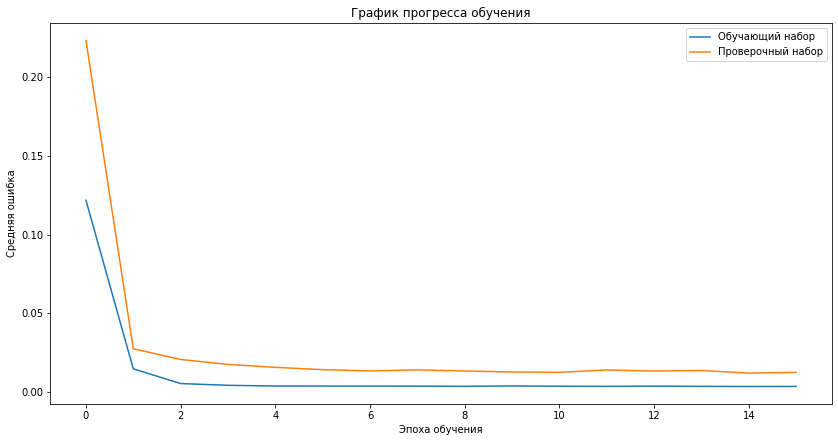

In [ ]:
plot_train(history)

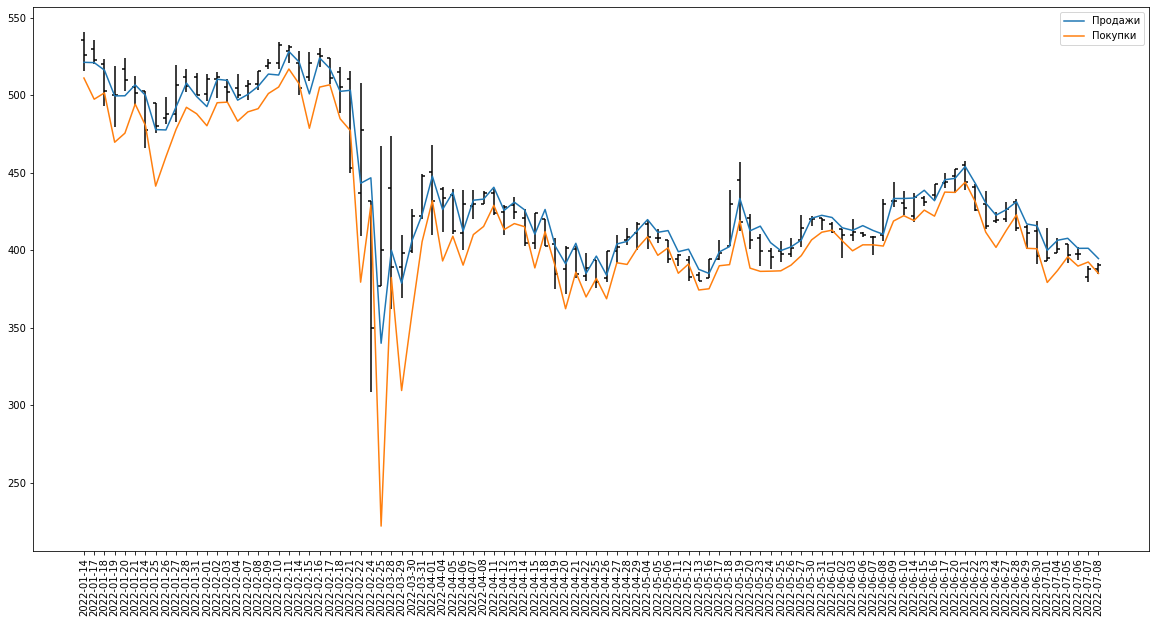

In [ ]:
# Получим результаты и визуализируем их
sep = int(len(df) * 0.9) + 2
y_pred = y_scaler.inverse_transform(model.predict(x_train[sep:], verbose=0))
test_df = df[sep + 1:]
y_true = test_df[['HIGH', 'LOW']].to_numpy()
plt.figure(figsize=(20, 10))
dtstr = make_finplot(test_df[-100:])
plt.plot(dtstr, y_pred[-100:, 0], label='Продажи')
plt.plot(dtstr, y_pred[-100:, 1], label='Покупки')
plt.legend()
plt.show()

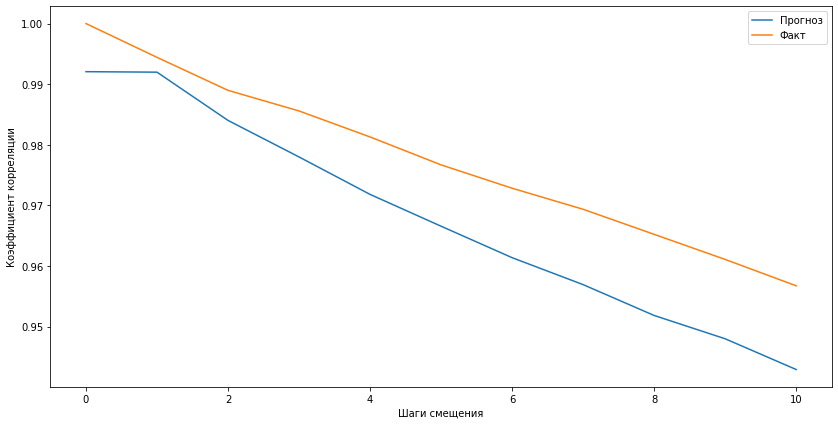

In [ ]:
plot_autocorr(y_pred, y_true, 10)

In [ ]:
def describe(y_pred, y_true, cls_true):
  '''Процедура выводит на печать описание относительной ошибки входа, выхода,
  относительного количества открытых позиций и закрытых в конце периода, 
  а также доход в рублях.
  Входящие параметры: 
  y_pred - прогноз, 
  y_true - факт, 
  cls_true - фактическая цена закрытия.'''
  low_pred = np.round(y_pred[:, 1], 2)
  low_true = y_true[:, 1]
  high_pred = np.round(y_pred[:, 0], 2)
  high_true = y_true[:, 0]
  maelow = round(abs(low_pred - low_true).mean(), 2)
  print('Средняя ошибка входа', maelow, 'руб., относительная ошибка',
        round(maelow / low_true.mean() * 100, 2), '%')
  maehigh = round(abs(high_pred - high_true).mean(), 2)
  print('Средняя ошибка выхода', maehigh, 'руб., относительная ошибка', 
        round(maehigh / high_true.mean() * 100, 2), '%')
  op = 1 * (low_true <= low_pred) * (high_true >= low_pred)
  len_test = len(op)
  print('Процент открытых позиций', round(sum(op) * 100 / len_test, 2), '%')
  fail = sum(1 * (high_true < high_pred))
  print('Процент закрытых позиций в конце дня', round(fail * 100 / len_test,
                                                      2), '%')
  price_op = op * low_pred
  price_cp = op * (high_pred * (high_true >= high_pred) + cls_true * \
                        (high_true < high_pred))
  profit = price_cp - price_op
  print('Доход составит', round(sum(profit), 2), 'рублей')
  return price_op, price_cp

In [ ]:
price_op, price_cp = describe(y_pred, y_true, test_df.CLOSE.to_numpy(float))

Средняя ошибка входа 6.63 руб., относительная ошибка 1.68 %
Средняя ошибка выхода 6.33 руб., относительная ошибка 1.56 %
Процент открытых позиций 28.03 %
Процент закрытых позиций в конце дня 37.15 %
Доход составит 277.61 рублей


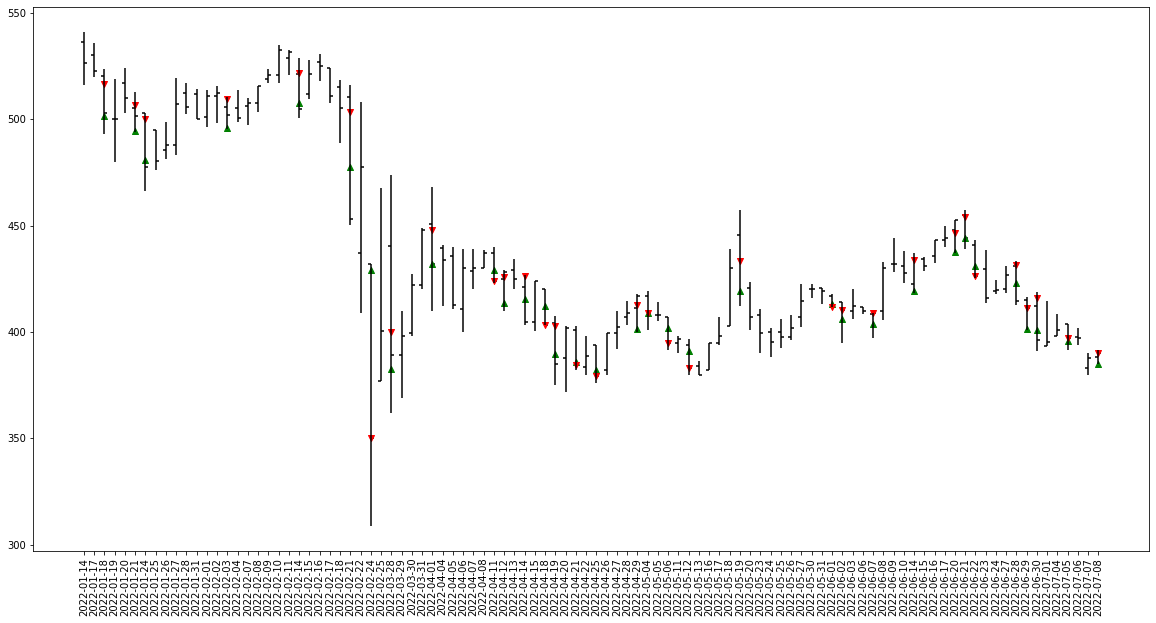

In [ ]:
# Визуализируем наши покупки и продажи
plt.figure(figsize=(20, 10))
dtstr = make_finplot(test_df[-100:])
price_op = price_op[-100:]
price_cp = price_cp[-100:]
plt.scatter(dtstr[price_op > 0], price_op[price_op > 0], marker='^', color='g')
plt.scatter(dtstr[price_cp > 0], price_cp[price_cp > 0], marker='v', color='r')
plt.show()

Эта модель хуже:
<ol>
<li>Выше ошибка входа и выхода;</li>
<li>Меньше процент открытых позиций;</li>
<li>Меньше доход.</li>
</ol>
<p>Из плюсов можно назвать почти отсутствие "горба" автокорреляции</p>

###Относительные выходные данные

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# Загружаем датасет
df = pd.read_csv('/content/drive/MyDrive/edu/sibn_clear.csv', 
                 index_col='TRADEDATE', parse_dates=['TRADEDATE'])
# Получаем описание данных
df.describe()

,OPEN,HIGH,LOW,CLOSE,VOLUME
count,4734.000000,4734.000000,4734.000000,4734.000000,4.734000e+03
mean,189.820032,192.363515,187.070913,189.686586,8.381682e+05
std,112.939412,114.149872,111.623746,112.844901,1.131448e+06
min,40.750000,43.600000,35.020000,40.150000,6.050000e+03
25%,115.427500,117.212500,113.142500,115.312500,2.238000e+05
50%,145.395000,146.800000,143.460000,145.200000,4.860755e+05
75%,231.350000,233.887500,228.237500,230.775000,1.063168e+06
max,552.000000,563.750000,546.450000,562.000000,2.336458e+07


Отношение минимума поля к максимуму составляет целый порядок, а в случае с объемом - 6 порядков. Посмотрим на корреляцию полей:

In [ ]:
df.corr()

,OPEN,HIGH,LOW,CLOSE,VOLUME
OPEN,1.000000,0.999521,0.999420,0.999343,0.013026
HIGH,0.999521,1.000000,0.998976,0.999451,0.020992
LOW,0.999420,0.998976,1.000000,0.999628,0.008606
CLOSE,0.999343,0.999451,0.999628,1.000000,0.015210
VOLUME,0.013026,0.020992,0.008606,0.015210,1.000000


Единственное поле, не коррелируещее с другими - объем, остальные почти идентичны друг другу. Кроме того, нам надо будет разработать систему, которая бы указывала, где следует покупать актив, а где продавать. Для решения этой задачи нам ежедневно надо предсказывать минимальное и максимальное значение. Можно также сформулировать и по-другому: где будет минимальное значение по отношению к закрытию предыдущего дня (покупка), а также как далеко будет максимум от минимума (волатильность).

In [ ]:
df['buy'] = df.LOW - df.CLOSE.shift()
df['volatility'] = df.HIGH - df.LOW
df['result'] = df.CLOSE - df.OPEN
df['gap'] = df.OPEN - df.CLOSE.shift()
# Из-за смещения получим пустое значение.
# Заменим это пустое значение на 0
df.buy.fillna(0, inplace=True)
df.gap.fillna(0, inplace=True)
df.describe()

,OPEN,HIGH,LOW,CLOSE,VOLUME,buy,volatility,result,gap
count,4734.000000,4734.000000,4734.000000,4734.000000,4.734000e+03,4734.000000,4734.000000,4734.000000,4734.000000
mean,189.820032,192.363515,187.070913,189.686586,8.381682e+05,-2.548437,5.292602,-0.133445,0.199905
std,112.939412,114.149872,111.623746,112.844901,1.131448e+06,4.580970,5.699089,4.094398,2.371422
min,40.750000,43.600000,35.020000,40.150000,6.050000e+03,-168.600000,0.480000,-82.100000,-45.300000
25%,115.427500,117.212500,113.142500,115.312500,2.238000e+05,-3.300000,2.500000,-1.547500,-0.280000
50%,145.395000,146.800000,143.460000,145.200000,4.860755e+05,-1.545000,3.870000,-0.060000,0.100000
75%,231.350000,233.887500,228.237500,230.775000,1.063168e+06,-0.500000,6.150000,1.437500,0.800000
max,552.000000,563.750000,546.450000,562.000000,2.336458e+07,27.000000,123.300000,40.450000,40.050000


Поля buy и volatility будут выходными, а остальные входными

In [ ]:
fieldset = ['buy', 'volatility']
y_data = df[fieldset].to_numpy('float')
x_data = df.drop(columns=fieldset).to_numpy('float')
print(x_data.shape, y_data.shape)

(4734, 7) (4734, 2)


In [ ]:
# Поделим на обучающую и проверочную часть
sep = int(len(y_data) * 0.9)
seq_len = 5
bs = 32
x_train = x_data[:sep]
y_train = y_data[:sep]
x_test = x_data[sep + seq_len * 2:]
y_test = y_data[sep + seq_len * 2:]
# масштабируем
x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)
# Генератор для обучения
train_datagen = TimeseriesGenerator(x_train, y_train, length=seq_len, 
                                    batch_size=bs)
# Генератор валидации
val_datagen = TimeseriesGenerator(x_test, y_test, length=seq_len, 
                                  batch_size=bs)
# Генератор тестовой выборки
test_datagen = TimeseriesGenerator(x_test, y_test, length=seq_len, 
                                   batch_size=len(x_test))
# данные для проверки
test_x, test_y = test_datagen[0]
print(test_x.shape, test_y.shape)

(459, 5, 7) (459, 2)


In [ ]:
# Полносвязная сеть
model = Sequential()
model.add(Dense(128, input_shape=test_x.shape[1:], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(test_y.shape[1], activation='linear'))
model.compile(optimizer=Adam(1e-4), loss='mae', metrics=['mse'])
history = model.fit(train_datagen, epochs=16, validation_data=val_datagen)

Epoch 1/16
133/133 [==============================] - 1s 6ms/step - loss: 0.2218 - mse: 0.1353 - val_loss: 0.3225 - val_mse: 0.2086
Epoch 2/16
133/133 [==============================] - 1s 4ms/step - loss: 0.0437 - mse: 0.0071 - val_loss: 0.1005 - val_mse: 0.0355
Epoch 3/16
133/133 [==============================] - 1s 4ms/step - loss: 0.0296 - mse: 0.0025 - val_loss: 0.0990 - val_mse: 0.0347
Epoch 4/16
133/133 [==============================] - 1s 4ms/step - loss: 0.0286 - mse: 0.0024 - val_loss: 0.0851 - val_mse: 0.0292
Epoch 5/16
133/133 [==============================] - 1s 4ms/step - loss: 0.0280 - mse: 0.0023 - val_loss: 0.0824 - val_mse: 0.0278
Epoch 6/16
133/133 [==============================] - 1s 4ms/step - loss: 0.0273 - mse: 0.0022 - val_loss: 0.0927 - val_mse: 0.0316
Epoch 7/16
133/133 [==============================] - 1s 4ms/step - loss: 0.0271 - mse: 0.0022 - val_loss: 0.0816 - val_mse: 0.0280
Epoch 8/16
133/133 [==============================] - 1s 4ms/step - loss: 0.

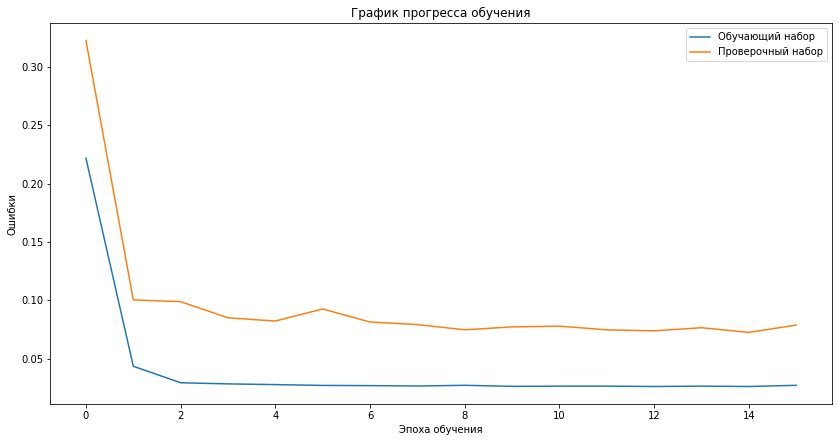

In [ ]:
plot_train(history)

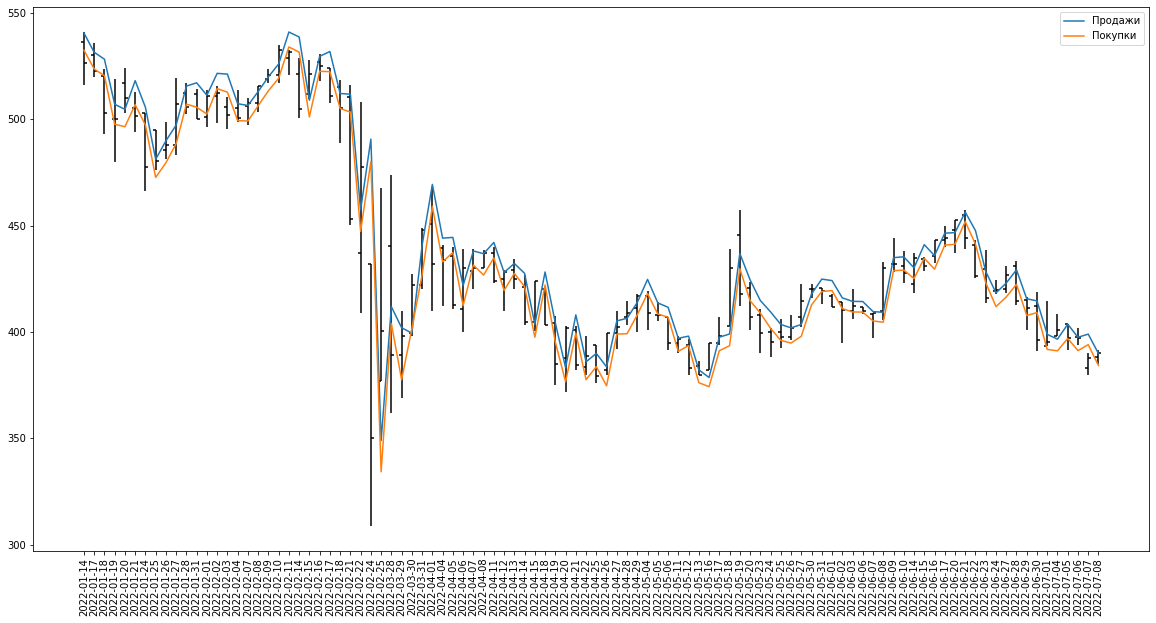

In [ ]:
y_pred = y_scaler.inverse_transform(model.predict(test_x, verbose=0))
len_test = len(test_x)
test_df = df[-len_test:]
y_true = test_df[['HIGH', 'LOW']].to_numpy(float)
# Восстановим данные, для этого получим смещенный ряд закрытия
cprev = df.CLOSE[-len_test - 1:-1].to_numpy()
# Восстанавливаем предсказанный вход в позицию
low_pred = np.round(y_pred[:, 0] + cprev, 2)
# Восстанавливаем выход из позиции
high_pred = np.round(low_pred + y_pred[:, 1], 2)
plt.figure(figsize=(20, 10))
dtstr = make_finplot(test_df[-100:])
plt.plot(dtstr, high_pred[-100:], label='Продажи')
plt.plot(dtstr, low_pred[-100:], label='Покупки')
plt.legend()
plt.show()

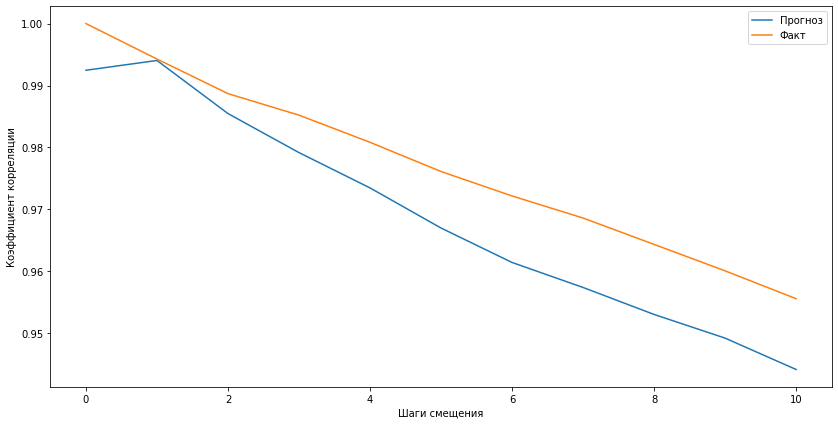

In [ ]:
y_pred = np.stack((high_pred, low_pred), axis=1)
plot_autocorr(y_pred, y_true, 10)

In [ ]:
price_op, price_cp = describe(y_pred, y_true, test_df.CLOSE.to_numpy(float))

Средняя ошибка входа 5.66 руб., относительная ошибка 1.43 %
Средняя ошибка выхода 4.86 руб., относительная ошибка 1.19 %
Процент открытых позиций 57.73 %
Процент закрытых позиций в конце дня 41.83 %
Доход составит 312.51 рублей


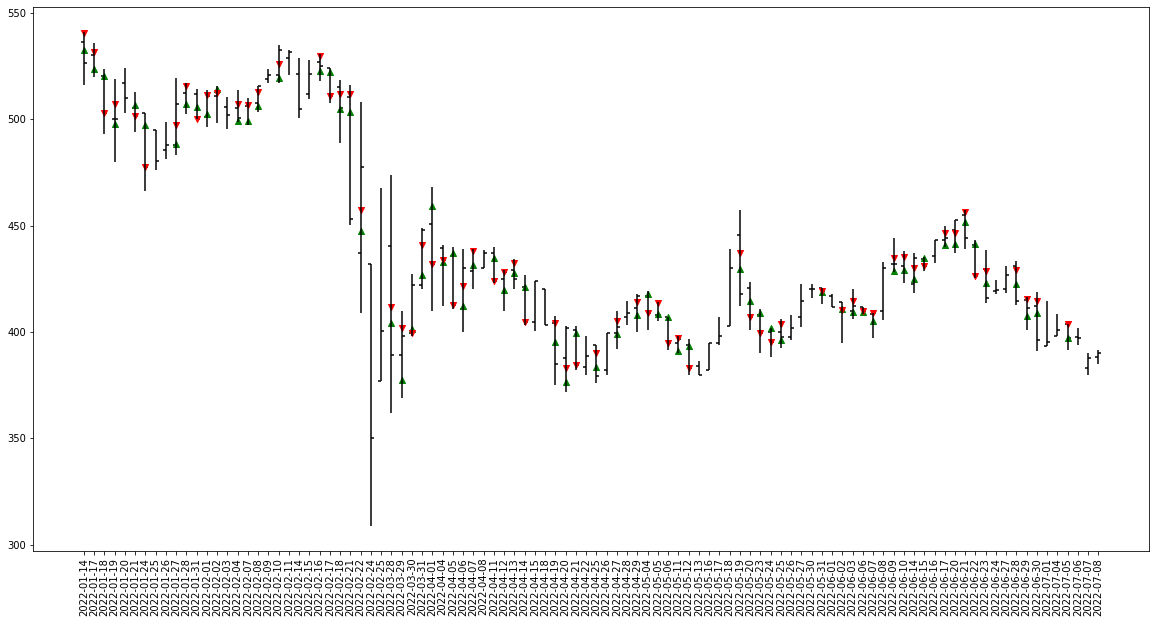

In [ ]:
# Визуализируем наши покупки и продажи
plt.figure(figsize=(20, 10))
dtstr = make_finplot(test_df[-100:])
price_op = price_op[-100:]
price_cp = price_cp[-100:]
plt.scatter(dtstr[price_op > 0], price_op[price_op > 0], marker='^', color='g')
plt.scatter(dtstr[price_cp > 0], price_cp[price_cp > 0], marker='v', color='r')
plt.show()

Результаты хуже базового варианта

###Минутные данные

In [ ]:
# Загружаем датасет
df = pd.read_csv('/content/drive/MyDrive/edu/sibn_minute.csv', 
                 index_col='begin', parse_dates=['begin'])
# Создаем дополнительные поля даты и времени
df['date'] = df.index.date
df['time'] = df.index.time
# Развернем поле close каждую минуту как колонку
df_day = df.pivot(index='date', columns='time', values='close')
# вот как это будет выглядеть
df_day.head()

time,09:59:00,10:00:00,10:01:00,10:02:00,10:03:00,10:04:00,10:05:00,10:06:00,10:07:00,10:08:00,...,21:52:00,21:53:00,21:55:00,21:57:00,21:58:00,21:59:00,22:01:00,22:05:00,22:07:00,22:09:00
date,,,,,,,,,,,,,,,,,,,,,
2011-12-15,NaN,132.81,132.80,NaN,134.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-16,NaN,138.04,138.00,137.80,137.80,137.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-19,NaN,136.36,137.44,NaN,137.00,NaN,NaN,137.00,NaN,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-20,NaN,NaN,NaN,137.43,NaN,NaN,NaN,137.59,137.59,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-21,NaN,141.74,NaN,141.30,141.29,NaN,141.4,NaN,NaN,141.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Мы получили много пустых полей, заполним их.
df_day.fillna(method='bfill', axis=1, inplace=True)
df_day.fillna(method='ffill', axis=1, inplace=True)
# теперь пустот нет
df_day.head()

time,09:59:00,10:00:00,10:01:00,10:02:00,10:03:00,10:04:00,10:05:00,10:06:00,10:07:00,10:08:00,...,21:52:00,21:53:00,21:55:00,21:57:00,21:58:00,21:59:00,22:01:00,22:05:00,22:07:00,22:09:00
date,,,,,,,,,,,,,,,,,,,,,
2011-12-15,132.81,132.81,132.80,134.00,134.00,133.37,133.37,133.37,133.37,133.37,...,136.50,136.50,136.50,136.50,136.50,136.50,136.50,136.50,136.50,136.50
2011-12-16,138.04,138.04,138.00,137.80,137.80,137.80,137.29,137.29,137.29,137.29,...,138.28,138.28,138.28,138.28,138.28,138.28,138.28,138.28,138.28,138.28
2011-12-19,136.36,136.36,137.44,137.00,137.00,137.00,137.00,137.00,137.00,137.00,...,138.40,138.40,138.40,138.40,138.40,138.40,138.40,138.40,138.40,138.40
2011-12-20,137.43,137.43,137.43,137.43,137.59,137.59,137.59,137.59,137.59,138.00,...,140.74,140.74,140.74,140.74,140.74,140.74,140.74,140.74,140.74,140.74
2011-12-21,141.74,141.74,141.30,141.30,141.29,141.40,141.40,141.90,141.90,141.90,...,141.00,141.00,141.00,141.00,141.00,141.00,141.00,141.00,141.00,141.00


In [ ]:
#проверим наличие пустых значений
ts = df_day.isna().sum()
ts[ts > 0]

Series([], dtype: int64)

In [ ]:
# Формирование выходных данных
agg_func = {'open':'first', 'high': 'max', 'low': 'min', 'close': 'last'}
df_y = df.groupby('date').agg(agg_func)
# со смещением на 1 день 2 и 3 признаки
y_data = df_y.iloc[1:, 1:3].to_numpy('float')
# Входными данными будет развернутая таблица тоже со смещением
x_data = df_day[:-1].to_numpy('float')
print(y_data.shape, x_data.shape)

(2649, 2) (2649, 547)


In [ ]:
# Масштабируем данные
x_scaler = MinMaxScaler()
x_train = x_scaler.fit_transform(x_data)
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_data)

In [ ]:
# Полносвязная сеть
model = Sequential()
model.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1], activation='linear'))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mse'])
history = model.fit(x_train, y_train, batch_size=32, epochs=16, 
                    validation_split=0.1)

Epoch 1/16
75/75 [==============================] - 1s 4ms/step - loss: 0.0191 - mse: 0.0022 - val_loss: 0.0273 - val_mse: 0.0012
Epoch 2/16
75/75 [==============================] - 0s 3ms/step - loss: 0.0071 - mse: 1.3867e-04 - val_loss: 0.0302 - val_mse: 0.0017
Epoch 3/16
75/75 [==============================] - 0s 3ms/step - loss: 0.0064 - mse: 1.1582e-04 - val_loss: 0.0289 - val_mse: 0.0015
Epoch 4/16
75/75 [==============================] - 0s 3ms/step - loss: 0.0069 - mse: 1.2802e-04 - val_loss: 0.0251 - val_mse: 0.0014
Epoch 5/16
75/75 [==============================] - 0s 3ms/step - loss: 0.0068 - mse: 1.2662e-04 - val_loss: 0.0159 - val_mse: 8.5109e-04
Epoch 6/16
75/75 [==============================] - 0s 3ms/step - loss: 0.0068 - mse: 1.2522e-04 - val_loss: 0.0280 - val_mse: 0.0014
Epoch 7/16
75/75 [==============================] - 0s 3ms/step - loss: 0.0072 - mse: 1.3819e-04 - val_loss: 0.0183 - val_mse: 0.0010
Epoch 8/16
75/75 [==============================] - 0s 3ms/ste

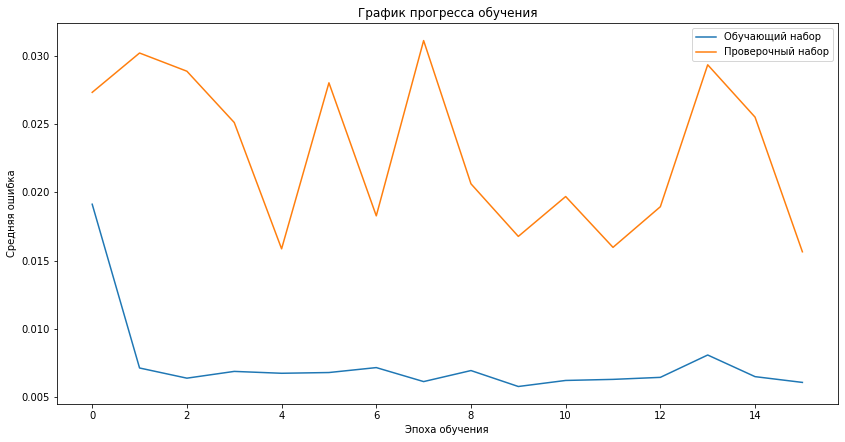

In [ ]:
plot_train(history)

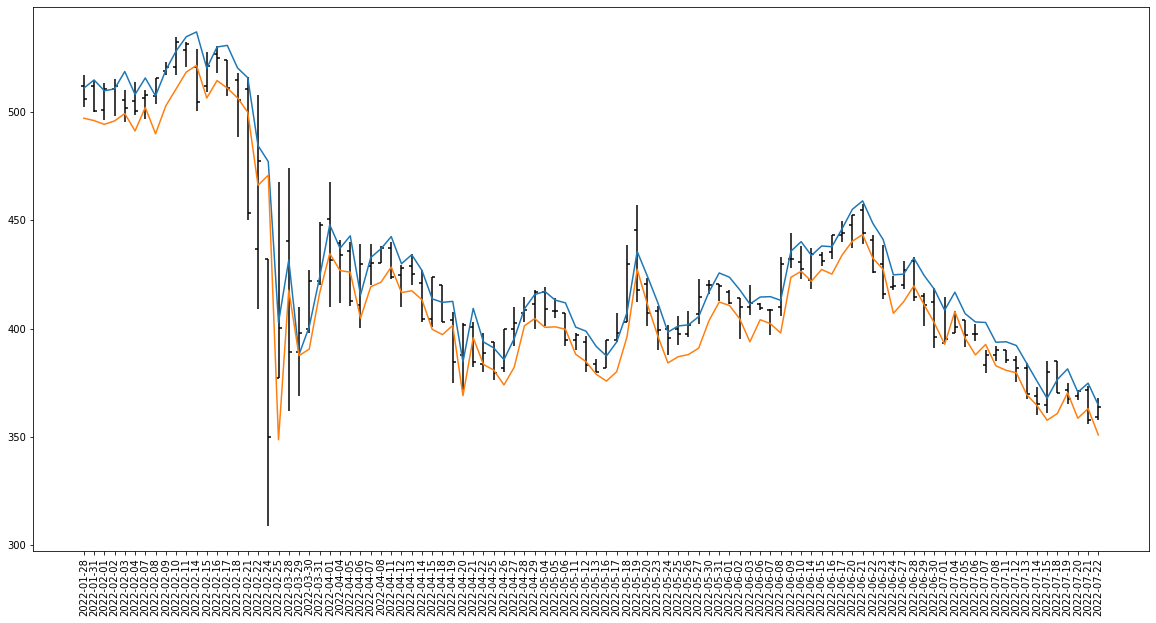

In [ ]:
y_pred = y_scaler.inverse_transform(model.predict(x_train[-400:], verbose=0))
y_true = y_data[-400:]
# Сформируем датафрейм для графика
test_df = df_y.iloc[-400:]
plt.figure(figsize=(20, 10))
dtstr = make_finplot(test_df[-100:])
plt.plot(dtstr, y_pred[-100:, 0])
plt.plot(dtstr, y_pred[-100:, 1])
plt.show()

In [ ]:
price_op, price_cp = describe(y_pred, y_true, test_df.close.to_numpy(float))

Средняя ошибка входа 6.48 руб., относительная ошибка 1.57 %
Средняя ошибка выхода 4.99 руб., относительная ошибка 1.17 %
Процент открытых позиций 27.5 %
Процент закрытых позиций в конце дня 56.75 %
Доход составит 238.78 рублей


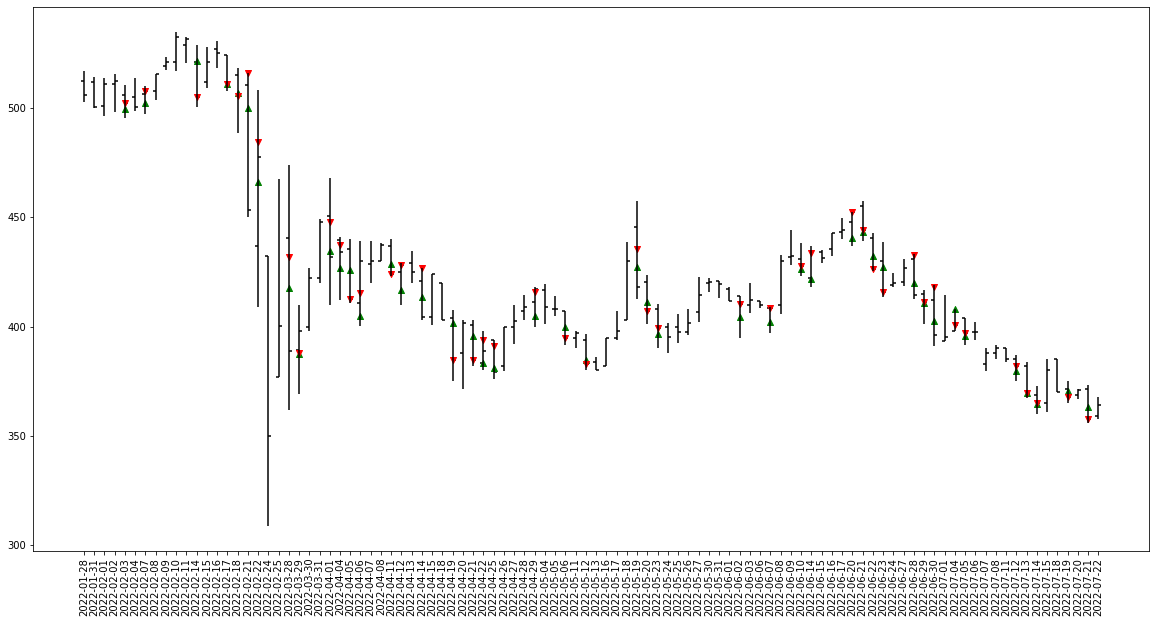

In [ ]:
# Визуализируем наши покупки и продажи
plt.figure(figsize=(20, 10))
dtstr = make_finplot(test_df[-100:])
price_op = price_op[-100:]
price_cp = price_cp[-100:]
plt.scatter(dtstr[price_op > 0], price_op[price_op > 0], marker='^', color='g')
plt.scatter(dtstr[price_cp > 0], price_cp[price_cp > 0], marker='v', color='r')
plt.show()

Результаты этого варианта неплохие

###Сверточные слои

In [ ]:
# Добавляем сверточный и пуллинговый сои
from keras.layers import Conv1D, MaxPooling1D

In [ ]:
# Загружаем датасет
df = pd.read_csv('/content/drive/MyDrive/edu/sibn_minute.csv', 
                 index_col='begin', parse_dates=['begin'])
# Создаем дополнительные поля даты и времени
df['date'] = df.index.date
df['time'] = df.index.time

In [ ]:
def get_mat(pname):
  '''Функция возвращает numpy-массив значений pname каждого дня по строкам,
  а по колонкам каждой минуты. Недостающие заполняются соседними.'''
  ret = df.pivot(index='date', columns='time', values=pname)
  ret.fillna(method='bfill', axis=1, inplace=True)
  ret.fillna(method='ffill', axis=1, inplace=True)
  return ret.to_numpy('float')

In [ ]:
# Входные данные
open = get_mat('open')
high = get_mat('high')
low = get_mat('low')
close = get_mat('close')
data = np.stack([open, high, low, close], axis=2)
# Выходные данные
agg_func = {'open':'first', 'high': 'max', 'low': 'min', 'close': 'last'}
df_y = df.groupby('date').agg(agg_func)
# со смещением на 1 день, 2 и 3 столбец
y_data = df_y.iloc[1:, 1:3].to_numpy(float)
# Входными данными будет развернутая таблица тоже со смещением
x_data = data[:-1]
print(y_data.shape, x_data.shape)

(2649, 2) (2649, 547, 4)


In [ ]:
# Нормализуем данные вручную, так как входные данные имеют 3 размерности
pmax = y_data.max()
pmin = y_data.min()
x_data = (x_data - pmin) / (pmax - pmin)
y_data = (y_data - pmin) / (pmax - pmin)
# Строим модель со сверточными слоями
model = Sequential()
model.add(Dense(128, input_shape=x_data.shape[1:], activation='relu'))
model.add(Conv1D(128, 8, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(128, 8, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(128, 8, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(y_data.shape[1], activation='linear'))
model.summary()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mse'])
history = model.fit(x_data, y_data, batch_size=32, epochs=16, 
                    validation_split=0.1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 547, 128)          640       
                                                                 
 conv1d_15 (Conv1D)          (None, 540, 128)          131200    
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 270, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 266, 128)          82048     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 133, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 126, 128)         

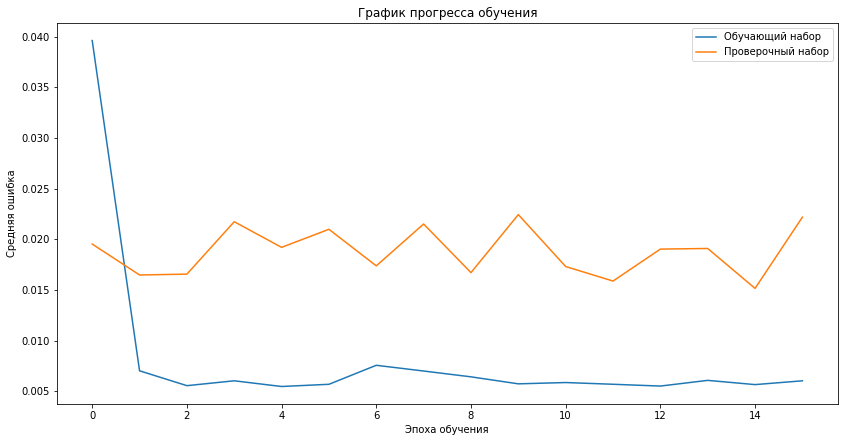

In [ ]:
plot_train(history)

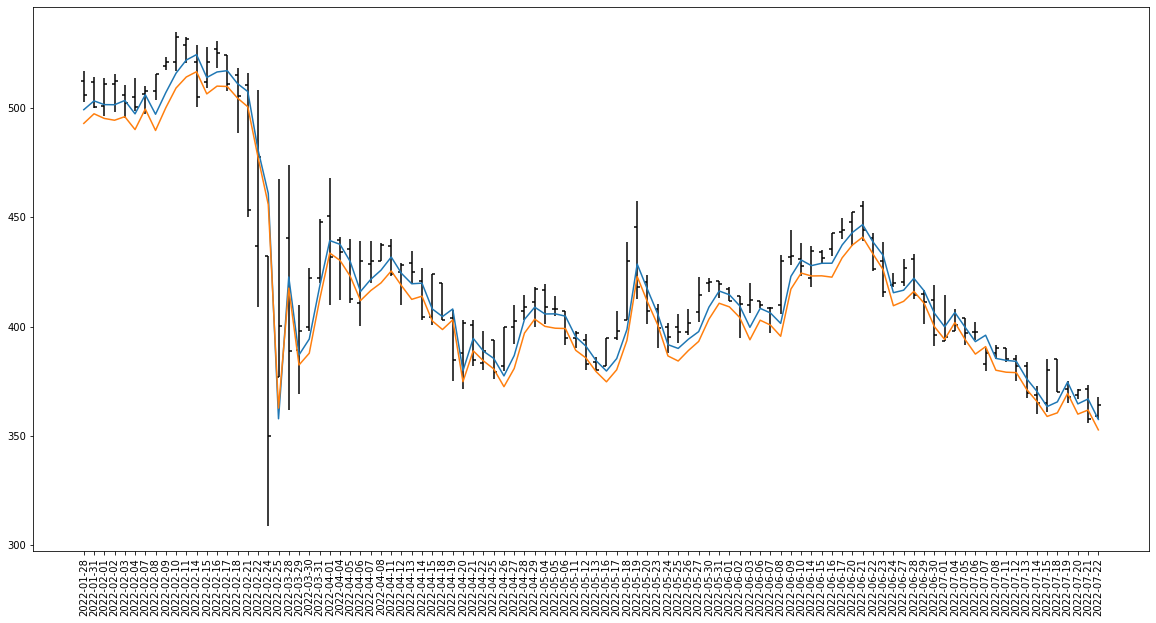

In [ ]:
y_pred = model.predict(x_data[-400:], verbose=0)
y_pred = y_pred * (pmax - pmin) + pmin
test_df = df_y[-400:]
y_true = test_df.iloc[:, 1:3].to_numpy('float')
plt.figure(figsize=(20, 10))
dtstr = make_finplot(test_df[-100:])
plt.plot(dtstr, y_pred[-100:, 0])
plt.plot(dtstr, y_pred[-100:, 1])
plt.show()

In [ ]:
price_op, price_cp = describe(y_pred, y_true, test_df.close.to_numpy(float))

Средняя ошибка входа 7.24 руб., относительная ошибка 1.75 %
Средняя ошибка выхода 9.9 руб., относительная ошибка 2.32 %
Процент открытых позиций 24.75 %
Процент закрытых позиций в конце дня 2.5 %
Доход составит 474.53 рублей


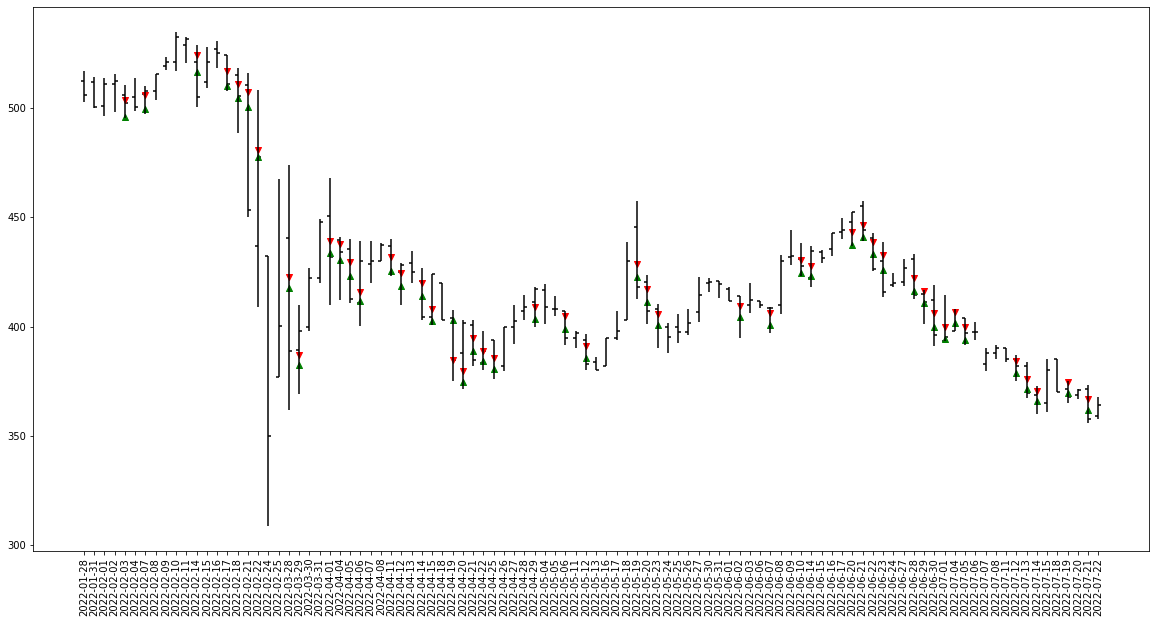

In [ ]:
plt.figure(figsize=(20, 10))
dtstr = make_finplot(test_df[-100:])
price_op = price_op[-100:]
price_cp = price_cp[-100:]
plt.scatter(dtstr[price_op > 0], price_op[price_op > 0], marker='^', color='g')
plt.scatter(dtstr[price_cp > 0], price_cp[price_cp > 0], marker='v', color='r')
plt.show()

Это пока лучший результат

###Слой LSTM

In [ ]:
# Загрузим этот слой
from keras.layers import LSTM
# Загружаем датасет
df = pd.read_csv('/content/drive/MyDrive/edu/sibn_minute.csv', 
                 index_col='begin', parse_dates=['begin'])
# Создаем дополнительные поля даты и времени
df['date'] = df.index.date
df['time'] = df.index.time
# Входные данные
open = get_mat('open')
high = get_mat('high')
low = get_mat('low')
close = get_mat('close')
data = np.stack([open, high, low, close], axis=2)
# Выходные данные
agg_func = {'open':'first', 'high': 'max', 'low': 'min', 'close': 'last'}
df_y = df.groupby('date').agg(agg_func)
# со смещением на 1 день, 2 и 3 столбец
y_data = df_y.iloc[1:, 1:3].to_numpy(float)
# Входными данными будет развернутая таблица тоже со смещением
x_data = data[:-1]
# Нормализуем данные вручную, так как входные данные имеют 3 размерности
pmax = y_data.max()
pmin = y_data.min()
x_data = (x_data - pmin) / (pmax - pmin)
y_data = (y_data - pmin) / (pmax - pmin)
# Строим модель со слоем LTSM
model = Sequential()
model.add(Dense(128, input_shape=x_data.shape[1:], activation='relu'))
model.add(LSTM(128))
model.add(Flatten())
model.add(Dense(y_data.shape[1], activation='linear'))
model.summary()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mse'])
history = model.fit(x_data, y_data, batch_size=32, epochs=16, 
                    validation_split=0.1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 547, 128)          640       
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                 258       
                                                                 
Total params: 132,482
Trainable params: 132,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/16
75/75 [==============================] - 4s 35ms/step - loss: 0.0677 - mse: 0.0190 - val_loss: 0.0151 - val_mse: 8.3325e-04
Epoch 2/16
75/75 [===========================

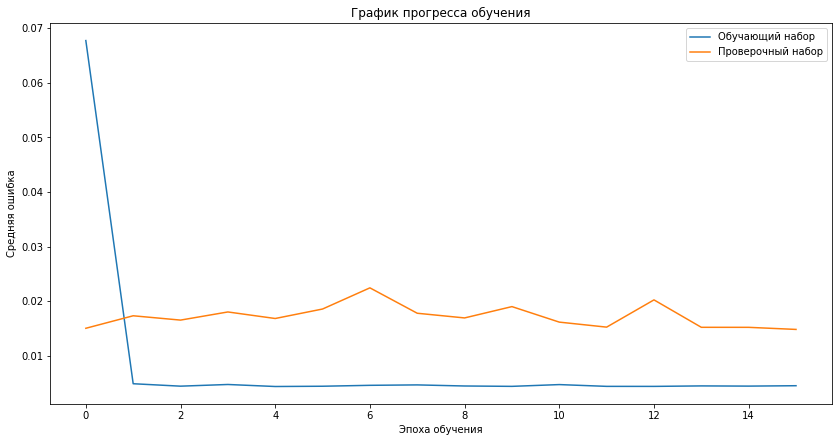

In [ ]:
plot_train(history)

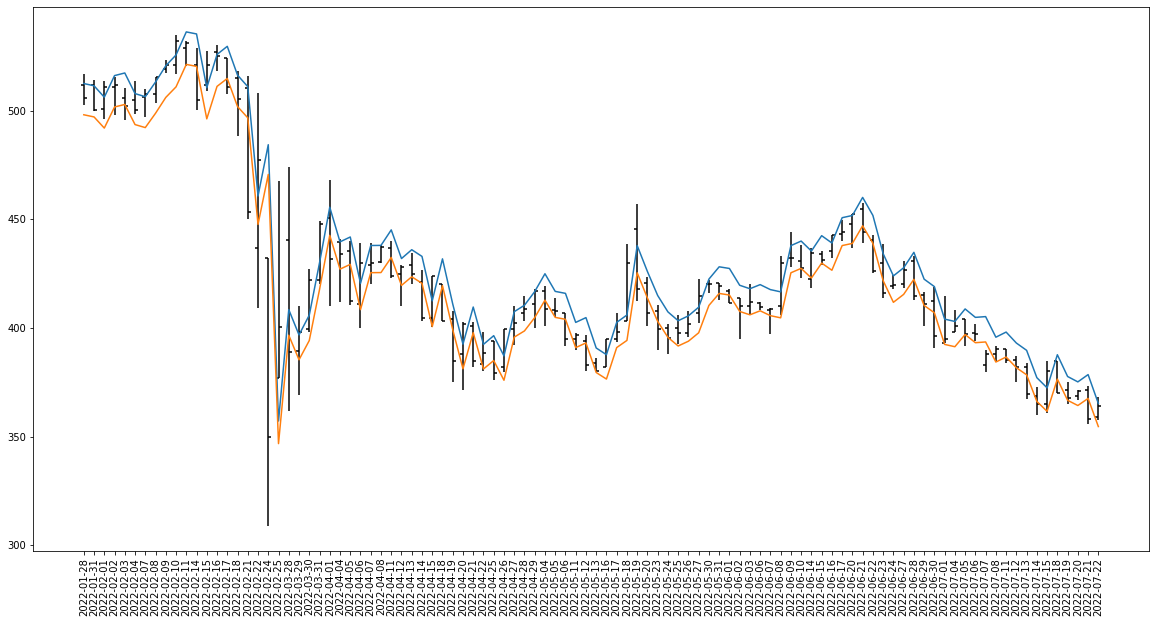

In [ ]:
y_pred = model.predict(x_data[-400:], verbose=0)
y_pred = y_pred * (pmax - pmin) + pmin
test_df = df_y[-400:]
y_true = test_df.iloc[:, 1:3].to_numpy('float')
plt.figure(figsize=(20, 10))
dtstr = make_finplot(test_df[-100:])
plt.plot(dtstr, y_pred[-100:, 0])
plt.plot(dtstr, y_pred[-100:, 1])
plt.show()

In [ ]:
price_op, price_cp = describe(y_pred, y_true, test_df.close.to_numpy(float))

Средняя ошибка входа 5.47 руб., относительная ошибка 1.32 %
Средняя ошибка выхода 5.72 руб., относительная ошибка 1.34 %
Процент открытых позиций 41.0 %
Процент закрытых позиций в конце дня 63.25 %
Доход составит 286.15 рублей


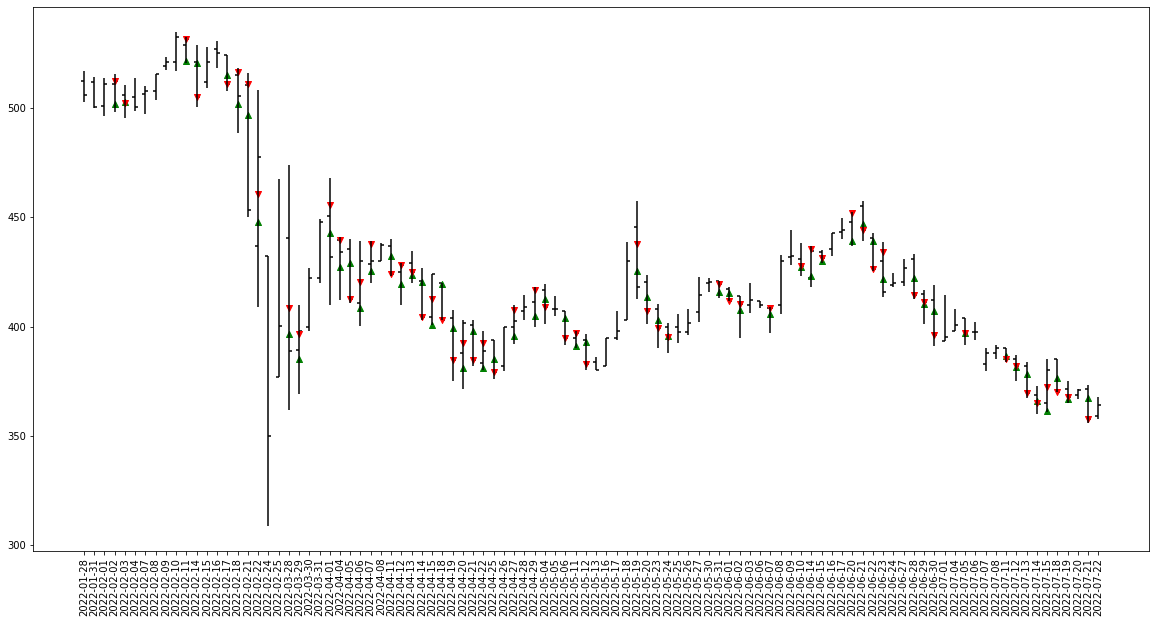

In [ ]:
plt.figure(figsize=(20, 10))
dtstr = make_finplot(test_df[-100:])
price_op = price_op[-100:]
price_cp = price_cp[-100:]
plt.scatter(dtstr[price_op > 0], price_op[price_op > 0], marker='^', color='g')
plt.scatter(dtstr[price_cp > 0], price_cp[price_cp > 0], marker='v', color='r')
plt.show()

Результат средний, с учетом сложности настройки реккурентных сетей, то хороший

###Слой GRU

In [ ]:
# Загрузим этот слой
from keras.layers import GRU
# Загружаем датасет
df = pd.read_csv('/content/drive/MyDrive/edu/sibn_minute.csv', 
                 index_col='begin', parse_dates=['begin'])
# Создаем дополнительные поля даты и времени
df['date'] = df.index.date
df['time'] = df.index.time
# Входные данные
open = get_mat('open')
high = get_mat('high')
low = get_mat('low')
close = get_mat('close')
data = np.stack([open, high, low, close], axis=2)
# Выходные данные
agg_func = {'open':'first', 'high': 'max', 'low': 'min', 'close': 'last'}
df_y = df.groupby('date').agg(agg_func)
# со смещением на 1 день, 2 и 3 столбец
y_data = df_y.iloc[1:, 1:3].to_numpy(float)
# Входными данными будет развернутая таблица тоже со смещением
x_data = data[:-1]
# Нормализуем данные вручную, так как входные данные имеют 3 размерности
pmax = y_data.max()
pmin = y_data.min()
x_data = (x_data - pmin) / (pmax - pmin)
y_data = (y_data - pmin) / (pmax - pmin)
# Строим модель со слоем LTSM
model = Sequential()
model.add(Dense(128, input_shape=x_data.shape[1:], activation='relu'))
model.add(GRU(128))
model.add(Flatten())
model.add(Dense(y_data.shape[1], activation='linear'))
model.summary()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mse'])
history = model.fit(x_data, y_data, batch_size=32, epochs=16, 
                    validation_split=0.1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 547, 128)          640       
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 flatten_6 (Flatten)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 2)                 258       
                                                                 
Total params: 99,970
Trainable params: 99,970
Non-trainable params: 0
_________________________________________________________________
Epoch 1/16
75/75 [==============================] - 4s 29ms/step - loss: 0.1031 - mse: 0.0325 - val_loss: 0.0204 - val_mse: 9.8918e-04
Epoch 2/16
75/75 [=============================

Средняя ошибка входа 7.23 руб., относительная ошибка 1.75 %
Средняя ошибка выхода 5.16 руб., относительная ошибка 1.21 %
Процент открытых позиций 73.75 %
Процент закрытых позиций в конце дня 50.5 %
Доход составит 219.58 рублей


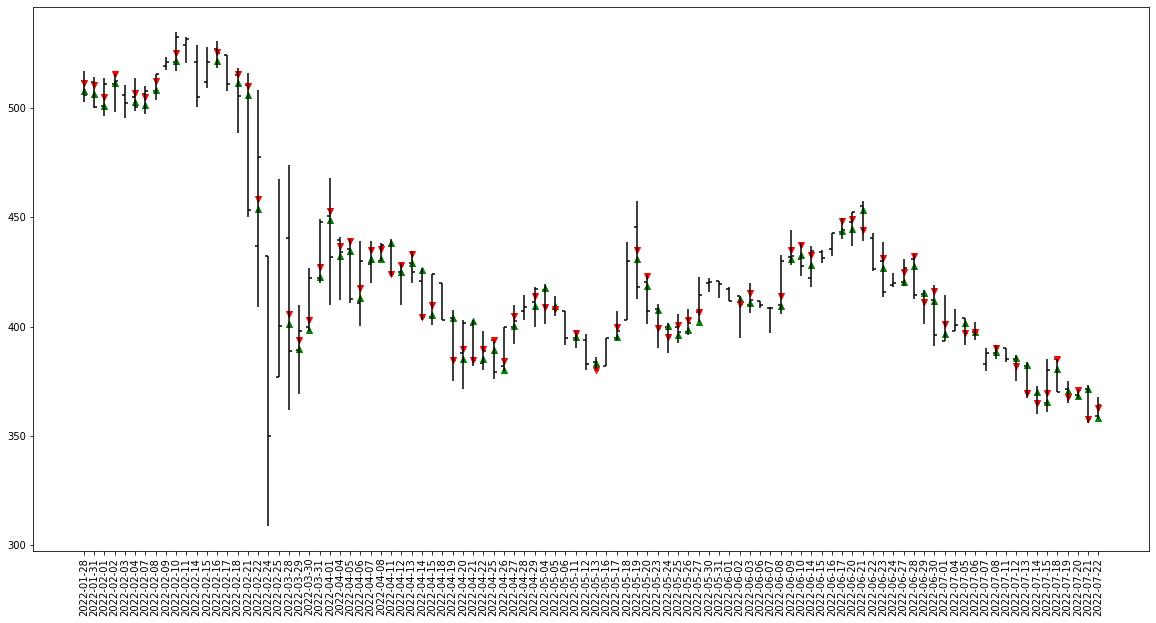

In [ ]:
y_pred = model.predict(x_data[-400:], verbose=0)
y_pred = y_pred * (pmax - pmin) + pmin
test_df = df_y[-400:]
y_true = test_df.iloc[:, 1:3].to_numpy('float')
price_op, price_cp = describe(y_pred, y_true, test_df.close.to_numpy(float))
plt.figure(figsize=(20, 10))
dtstr = make_finplot(test_df[-100:])
price_op = price_op[-100:]
price_cp = price_cp[-100:]
plt.scatter(dtstr[price_op > 0], price_op[price_op > 0], marker='^', color='g')
plt.scatter(dtstr[price_cp > 0], price_cp[price_cp > 0], marker='v', color='r')
plt.show()

Результат средний

##Окончательная архитектура

###Подбор архитектуры с помощью генетических алгоритмов

По результатам многочисленных экспериментов были определены "победители". Оба победителя используют минутные данные. Подберем оптимальную архитектуру с помощью генетического алгоритма.

In [ ]:
#Загрузим необходимые слои
from keras.layers import Input, Dropout
# Загружаем датасет
df = pd.read_csv('/content/drive/MyDrive/edu/sibn_minute.csv', 
                 index_col='begin', parse_dates=['begin'])
# Создаем дополнительные поля даты и времени
df['date'] = df.index.date
df['time'] = df.index.time
# Входные данные
open = get_mat('open')
high = get_mat('high')
low = get_mat('low')
close = get_mat('close')
data = np.stack([open, high, low, close], axis=2)
# Выходные данные
agg_func = {'open':'first', 'high': 'max', 'low': 'min', 'close': 'last'}
df_y = df.groupby('date').agg(agg_func)
# со смещением на 1 день, 2 и 3 столбец
y_data = df_y.iloc[1:, 1:3].to_numpy(float)
# Входными данными будет развернутая таблица тоже со смещением
x_data = data[:-1]
# Нормализуем данные вручную, так как входные данные имеют 3 размерности
pmax = y_data.max()
pmin = y_data.min()
x_data = (x_data - pmin) / (pmax - pmin)
y_data = (y_data - pmin) / (pmax - pmin)
sep = int(len(x_data) * 0.9)
x_train = x_data[:sep]
y_train = y_data[:sep]
x_test = x_data[sep:]
y_test = y_data[sep:]
y_true = df_y.to_numpy()[sep + 1:]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, y_true.shape)
# Выведем минимальные и максимальные значения для обратного преобразования
print(pmax, pmin)

In [ ]:
#Создаём сеть (net - список параметров)
def create_randnet(net):
  model = Sequential()
  model.add(Input(x_train.shape[1:]))
  act_list = ['linear','relu', 'elu', 'selu' ,'tanh']
  '''net[0] - тип слоя, 1 - размер слоя, 2 - тип активации, 
  3 - размер ядра для сверточного слоя (только при net[0] = 1), 
  4 - количество сверточных слоев (только при net[0] = 1),
  5 - наличие слоя дискретизации (только при net[0] = 1),
  6 - размер регуляционного слоя (0 - нет),
  7 - дополнительный полный слой, 8 - размер дополнительного слоя, 
  9 - тип активации дополнительного слоя'''
  LaySize1 = 2 ** int(net[1])
  Act1 = act_list[net[2]]
  if net[0]:
    model.add(Dense(LaySize1, activation=Act1))
  else:
    for _ in range(net[4]):
      model.add(Conv1D(LaySize1, int(net[3]), activation=Act1))
      if net[5]: model.add(MaxPooling1D())
  if net[6]: model.add(Dropout(int(round(net[6] / 10, 1))))
  if net[7]: model.add(Dense(2 ** int(net[8]), activation=act_list[net[9]]))
  model.add(Flatten())
  model.add(Dense(y_train.shape[1], activation='linear'))   
  return model

#Функция создания списка случайных параметров
def create_bot():
  net = []
  # 0 Тип слоя от 0 до 1
  net.append(np.random.randint(0, 2))
  # 1 Размер слоя от 3 до 10 
  net.append(np.random.randint(3, 11))
  # 2 Тип активации от 0 до 4 
  net.append(np.random.randint(0, 5))
  # 3 Размер ядра сверточного слоя от 2 до 8
  net.append(np.random.randint(2, 9))
  # 4 Количество сверточных слоев от 2 до 5
  net.append(np.random.randint(2, 6))
  # 5 Наличие слоя дискретизации
  net.append(np.random.randint(0, 2))
  # 6 Размер рег-слоя от 1 до 4 (при 0 слой отсутствует)
  net.append(np.random.randint(0, 5))
  # 7 Нужен ли еще полный слой 
  net.append(np.random.randint(0, 2))
  # 8 Размер дополнительного слоя
  net.append(np.random.randint(3, 11))
  # 9 Активация дополнительного слоя
  net.append(np.random.randint(0, 5))
  return net

# Функция вычисляет доход
def profit(high_pred, low_pred):
  op = 1 * (y_true[:, 2] <= low_pred) * (y_true[:, 1] >= low_pred)
  price_op = op * low_pred
  price_cp = op * (high_pred * (y_true[:, 1] >= high_pred) + y_true[:, 3] * \
                        (y_true[:, 1] < high_pred))
  profit = price_cp - price_op
  return round(sum(profit), 2)

# Функция вычисления результатов работы сети
def eval_net(net):
  model = create_randnet(net)
  model.compile(loss='mae', metrics=['mse'], optimizer=Adam(1e-4))
  #print('Обучение модели бота', net)
  history = model.fit(x_train, y_train, epochs=6, batch_size=32, verbose=0,
                      validation_split=0.1, shuffle=False)
  y_pred = model.predict(x_test, verbose=0)
  y_pred = y_pred * (pmax - pmin) + pmin
  return profit(y_pred[:, 0], y_pred[:, 1])

Собственно сам генетический алгоритм

In [ ]:
#Основные параметры для поиска
len_pop = 16
nsurv = 4
nnew = len_pop - nsurv
len_bot = 10
epochs = 20
# выход из поиска если изменение в лучших ниже данного значения
control_std = 0.001
mut = 0.5        # коэфициент мутаций
popul = np.array([create_bot() for _ in range(len_pop)])
b_con = False
for epoch in range(epochs):
    # Уменьшаем мутацию
    if epoch % 2 == 0:
        mut -= 0.1
    # Расчет ботов
    if b_con:
      val = np.array(tuple(map(eval_net, curpop)))
      val = np.hstack((best_val, val))
    else:
      b_con = True
      val = np.array(tuple(map(eval_net, popul)))
    # Получение лучших ботов из популяции
    best_idx = val.argsort()[::-1]
    best_bots = popul[best_idx]
    uni_bots = np.unique(best_bots)
    best_bots = best_bots[uni_bots]
    parents = best_bots[:nsurv]
    if np.std(parents) < control_std:
      print('Поиск лучших не дает нового, выход')
      break
    print('Прогон', epoch, 'лучший результат:', val.max(), parents[0])
    best_val = val[best_idx]
    best_val = best_val[uni_bots][:nsurv]
    newpopul = [create_bot() for _ in range(nnew)]
    curpop = np.array([[newpopul[i][j] if np.random.random() < mut else parents[
        np.random.choice(nsurv)][j] for j in range(len_bot)] for i in range(nnew)])
    popul = np.vstack((parents, curpop))

Прогон 0 лучший результат: 212.84 [0 8 4 8 4 1 2 0 6 1]
Прогон 1 лучший результат: 383.26 [0 5 0 7 4 1 0 0 4 0]
Прогон 2 лучший результат: 383.26 [0 5 0 7 4 1 0 0 4 0]
Прогон 3 лучший результат: 441.79 [0 6 1 7 4 1 4 0 5 0]
Прогон 4 лучший результат: 441.79 [0 6 1 7 4 1 4 0 5 0]
Прогон 5 лучший результат: 441.79 [0 6 1 7 4 1 4 0 5 0]
Прогон 6 лучший результат: 441.79 [0 6 1 7 4 1 4 0 5 0]
Прогон 7 лучший результат: 441.79 [0 6 1 7 4 1 4 0 5 0]
Прогон 8 лучший результат: 441.79 [0 6 1 7 4 1 4 0 5 0]
Прогон 9 лучший результат: 441.79 [0 6 1 7 4 1 4 0 5 0]
Прогон 10 лучший результат: 441.79 [0 6 1 7 4 1 4 0 5 0]
Прогон 11 лучший результат: 441.79 [0 6 1 7 4 1 4 0 5 0]
Прогон 12 лучший результат: 441.79 [0 6 1 7 4 1 4 0 5 0]
Прогон 13 лучший результат: 441.79 [0 6 1 7 4 1 4 0 5 0]
Прогон 14 лучший результат: 450.69 [0 6 1 7 4 1 2 0 5 3]
Прогон 15 лучший результат: 450.69 [0 6 1 7 4 1 2 0 5 3]
Прогон 16 лучший результат: 450.69 [0 6 1 7 4 1 2 0 5 3]
Прогон 17 лучший результат: 450.69 [0 6 1

In [ ]:
#Выведем 4 лучших значения 
print(*parents)
print(*best_val)

[0 6 1 7 4 1 2 0 5 3] [0 6 1 7 4 1 4 0 5 0] [0 6 1 7 4 1 4 0 5 0] [0 6 1 7 4 1 4 0 5 0]
450.69 444.57 441.79 434.38


In [ ]:
# Модель по лучшему боту
bot = parents[0]
model = create_randnet(bot)
model.summary()

Model: "sequential_244"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_909 (Conv1D)         (None, 541, 64)           1856      
                                                                 
 max_pooling1d_588 (MaxPooli  (None, 270, 64)          0         
 ng1D)                                                           
                                                                 
 conv1d_910 (Conv1D)         (None, 264, 64)           28736     
                                                                 
 max_pooling1d_589 (MaxPooli  (None, 132, 64)          0         
 ng1D)                                                           
                                                                 
 conv1d_911 (Conv1D)         (None, 126, 64)           28736     
                                                                 
 max_pooling1d_590 (MaxPooli  (None, 63, 64)        

In [ ]:
# Дообучим лучший бот
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mae', metrics=['mse'])
history = model.fit(x_train, y_train, batch_size=32, epochs=8, verbose=1,
                    validation_split=0.1, shuffle=False)

Epoch 1/8
68/68 [==============================] - 1s 10ms/step - loss: 0.1478 - mse: 0.0343 - val_loss: 0.2180 - val_mse: 0.0489
Epoch 2/8
68/68 [==============================] - 0s 6ms/step - loss: 0.0297 - mse: 0.0014 - val_loss: 0.0253 - val_mse: 7.0997e-04
Epoch 3/8
68/68 [==============================] - 0s 6ms/step - loss: 0.0152 - mse: 3.2523e-04 - val_loss: 0.0067 - val_mse: 7.8515e-05
Epoch 4/8
68/68 [==============================] - 0s 6ms/step - loss: 0.0107 - mse: 2.0016e-04 - val_loss: 0.0078 - val_mse: 1.0535e-04
Epoch 5/8
68/68 [==============================] - 0s 6ms/step - loss: 0.0088 - mse: 1.5240e-04 - val_loss: 0.0083 - val_mse: 1.1764e-04
Epoch 6/8
68/68 [==============================] - 0s 6ms/step - loss: 0.0079 - mse: 1.3242e-04 - val_loss: 0.0085 - val_mse: 1.2280e-04
Epoch 7/8
68/68 [==============================] - 0s 6ms/step - loss: 0.0070 - mse: 1.1502e-04 - val_loss: 0.0070 - val_mse: 8.9927e-05
Epoch 8/8
68/68 [==============================] - 0

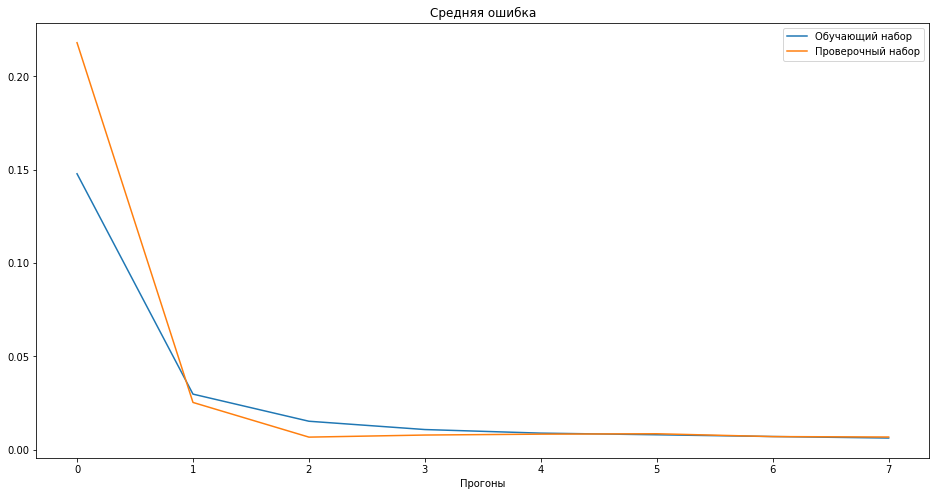

In [ ]:
plot_train(history)

In [ ]:
y_pred = model.predict(x_test, verbose=0)
y_pred = y_pred * (pmax - pmin) + pmin
profit(y_pred[:, 0], y_pred[:, 1])

313.32

Архитектура, подобранная генетикой:
*   Входной слой;
*   Сверточный блок, состоящий из 4 итераций: сверточный слой (64 нейрона, 7 ядер, функция активации - relu), слой MaxPooling1D;
*   Регуляционный слой (DropOut(0.2));
*   Выравнивающий слой;
*   Выходной блок: полносвязный слой (2 нейрона, функция активации - linear).




###Вариативность модели

Используем предыдущие данные

In [ ]:
# Функция вычисляет доход
def profit(high_pred, low_pred):
  op = 1 * (y_true[:, 2] <= low_pred) * (y_true[:, 1] >= low_pred)
  price_op = op * low_pred
  price_cp = op * (high_pred * (y_true[:, 1] >= high_pred) + y_true[:, 3] * \
                        (y_true[:, 1] < high_pred))
  profit = price_cp - price_op
  return round(sum(profit), 2)

# Функция вычисления результатов работы сети
def eval():
  model = Sequential()
  model.add(Input(x_train.shape[1:]))
  for _ in range(4):
    model.add(Conv1D(64, 7, activation='relu'))
    model.add(MaxPooling1D())
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(y_train.shape[1], activation='linear'))
  model.compile(loss='mae', metrics=['mse'], optimizer=Adam(1e-5))
  history = model.fit(x_train, y_train, epochs=6, batch_size=32, verbose=0,
                      validation_split=0.1, shuffle=False)
  y_pred = model.predict(x_test, verbose=0)
  y_pred = y_pred * (563.75 - 110.22) + 110.22
  return model, profit(y_pred[:, 0], y_pred[:, 1])

In [ ]:
#Основные параметры для поиска
max_val = 400.
epochs = 20
val = 0
for _ in range(epochs):
    model, val = eval()
    print(round(val, 2))
    if val > max_val:
      max_val = val
      model.save('/content/drive/MyDrive/edu/sibn.h5')

360.43
197.24
165.16
373.58
414.28
341.22
229.29
237.15
383.23
310.36
307.78
227.3
454.44
376.41
133.27
267.52
189.51
136.41
138.48
198.64


Модель с лучшим доходом сохранена в файл

##Проверка на новых данных

Оформим код, как если бы он был самостоятельным

In [ ]:
# Загружаем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

In [ ]:
# Чтение данных в таблицу Pandas и назначение имен столбцов
df_old = pd.read_csv('/content/drive/MyDrive/edu/sibn_minute.csv',
                   index_col='begin', parse_dates=['begin'])
# Узнаем последнюю дату первого набора 2022-07-22
df_old.index.max()

Timestamp('2022-07-22 18:49:00')

Для получения таких данных нам нужно проделать те же действия, что и при первом сборе данных, но уже с даты, которая не вошла в первый набор данных

In [ ]:
url = 'https://iss.moex.com/iss/engines/stock/markets/shares/boards/'
url += 'TQBR/securities/SIBN/candles.json?interval=1&from=2022-07-25&start='
filename = '/content/drive/MyDrive/edu/sibn_min_test.csv'
start = 0
size = 500
while size == 500:
    res = pd.read_json(url + str(start))
    jcandles = res['candles']
    jdata = jcandles['data']
    if start == 0:
        jcols = jcandles['columns']
        df = pd.DataFrame(jdata, columns=jcols)
        df.to_csv(filename, index=False)
    else:
        df = pd.DataFrame(jdata, columns=jcols)
        size = len(df)
        df.to_csv(filename, header=False, mode='a', index=False)
    start += size

In [ ]:
# Загрузим новые данные
df_new = pd.read_csv('/content/drive/MyDrive/edu/sibn_min_test.csv',
                 index_col='begin', parse_dates=['begin', 'end'])
df_new = df_new[['open', 'high', 'low', 'close', 'volume']]
len_new = len(df_new)
# Добавим новые данные к старым данным
df = df_old.append(df_new)
# Удаляем объем
df = df.drop('volume', axis=1)
# Создаем дополнительные поля даты и времени
df['date'] = df.index.date
df['time'] = df.index.time

In [ ]:
# Функция разворачивает время в качестве параметров, а дату, как записи
def get_mat(pname):
  ret = df.pivot(index='date', columns='time', values=pname)
  ret.fillna(method='bfill', axis=1, inplace=True)
  ret.fillna(method='ffill', axis=1, inplace=True)
  return ret.to_numpy('float')

In [ ]:
# формирование входных данных и их нормализация
open = get_mat('open')
open = open[-len_new:]
high = get_mat('high')
high = high[-len_new:]
low = get_mat('low')
low = low[-len_new:]
close = get_mat('close')
close = close[-len_new:]
# значения нормализации берем из ноутбука с генетикой
pmin = 110.22
pmax = 563.75
data = np.stack([open, high, low, close], axis=2)
x_data = (data - pmin) / (pmax - pmin)
# без последнего дня
x_data = x_data[:-1]
# Формирование выходных данных
agg_func = {'open':'first', 'high': 'max', 'low': 'min', 'close': 'last'}
df_y = df.loc['2022-07-25':].groupby('date').agg(agg_func)
# со смещением на 1 день 2 и 3 признаки
y_data = df_y.iloc[1:, 1:3].to_numpy('float')
# Масштабируем данные
y_data = (y_data - pmin) / (pmax - pmin)
y_true = df_y.iloc[1:].to_numpy('float')
print(x_data.shape, y_data.shape, y_true.shape)

(76, 547, 4) (76, 2) (76, 4)


In [ ]:
# Загрузим модель
model = load_model('/content/drive/MyDrive/edu/sibn.h5')
y_pred = model.predict(x_data, verbose=0)
y_pred = y_pred * (pmax - pmin) + pmin

In [ ]:
def make_finplot(df):
  '''Функция рисует график аналогично mplfinance, используя matplotlib.pyplot.
  В качестве единственного входящего параметра должен использоваться 
  DataFrame pandas, в котором индексом является временной ряд, 
  а четыре цены должны следовать в следующем порядке: открытие, максимум,
  минимум, закрытие
  Функция возвращает временной вектор в строковом формате'''
  strdt = df.index.astype('str')
  # Временной ряд переводим в текстовый формат, чтобы устранить неторговые 
  # промежутки, например, выходные дни
  spans = (df.iloc[:, 1] - df.iloc[:, 2]) / 2
  center = (df.iloc[:, 1] + df.iloc[:, 2]) / 2
  plt.errorbar(strdt, center, spans, ls='none', ecolor='k')
  # Рисуем вертикальные линии от минимума до максимума
  plt.scatter(strdt, df.iloc[:, 3], marker=1, s=10, color='k')
  # Рисуем засечку закрытия
  plt.scatter(strdt, df.iloc[:, 0], marker=0, s=10, color='k')
  # Рисуем засечку открытия
  plt.xticks(rotation=90)
  # Поворачиваем подписи на 90 градусов
  return strdt

def describe(y_pred, y_true, cls_true):
  '''Процедура выводит на печать описание относительной ошибки входа, выхода,
  относительного количества открытых позиций и закрытых в конце периода, 
  а также доход в рублях.
  Входящие параметры: 
  y_pred - прогноз, 
  y_true - факт, 
  cls_true - фактическая цена закрытия.'''
  low_pred = np.round(y_pred[:, 1], 2)
  low_true = y_true[:, 1]
  high_pred = np.round(y_pred[:, 0], 2)
  high_true = y_true[:, 0]
  maelow = round(abs(low_pred - low_true).mean(), 2)
  print('Средняя ошибка входа', maelow, 'руб., относительная ошибка',
        round(maelow / low_true.mean() * 100, 2), '%')
  maehigh = round(abs(high_pred - high_true).mean(), 2)
  print('Средняя ошибка выхода', maehigh, 'руб., относительная ошибка', 
        round(maehigh / high_true.mean() * 100, 2), '%')
  op = 1 * (low_true <= low_pred) * (high_true >= low_pred)
  len_test = len(op)
  print('Процент открытых позиций', round(sum(op) * 100 / len_test, 2), '%')
  fail = sum(1 * (high_true < high_pred))
  print('Процент закрытых позиций в конце дня', round(fail * 100 / len_test,
                                                      2), '%')
  price_op = op * low_pred
  price_cp = op * (high_pred * (high_true >= high_pred) + cls_true * \
                        (high_true < high_pred))
  profit = price_cp - price_op
  print('Доход составит', round(sum(profit), 2), 'рублей')
  return price_op, price_cp

In [ ]:
price_op, price_cp = describe(y_pred, y_true[:, 1:3], y_true[:, 3])

Средняя ошибка входа 7.93 руб., относительная ошибка 2.04 %
Средняя ошибка выхода 7.93 руб., относительная ошибка 1.96 %
Процент открытых позиций 21.05 %
Процент закрытых позиций в конце дня 15.79 %
Доход составит 33.28 рублей


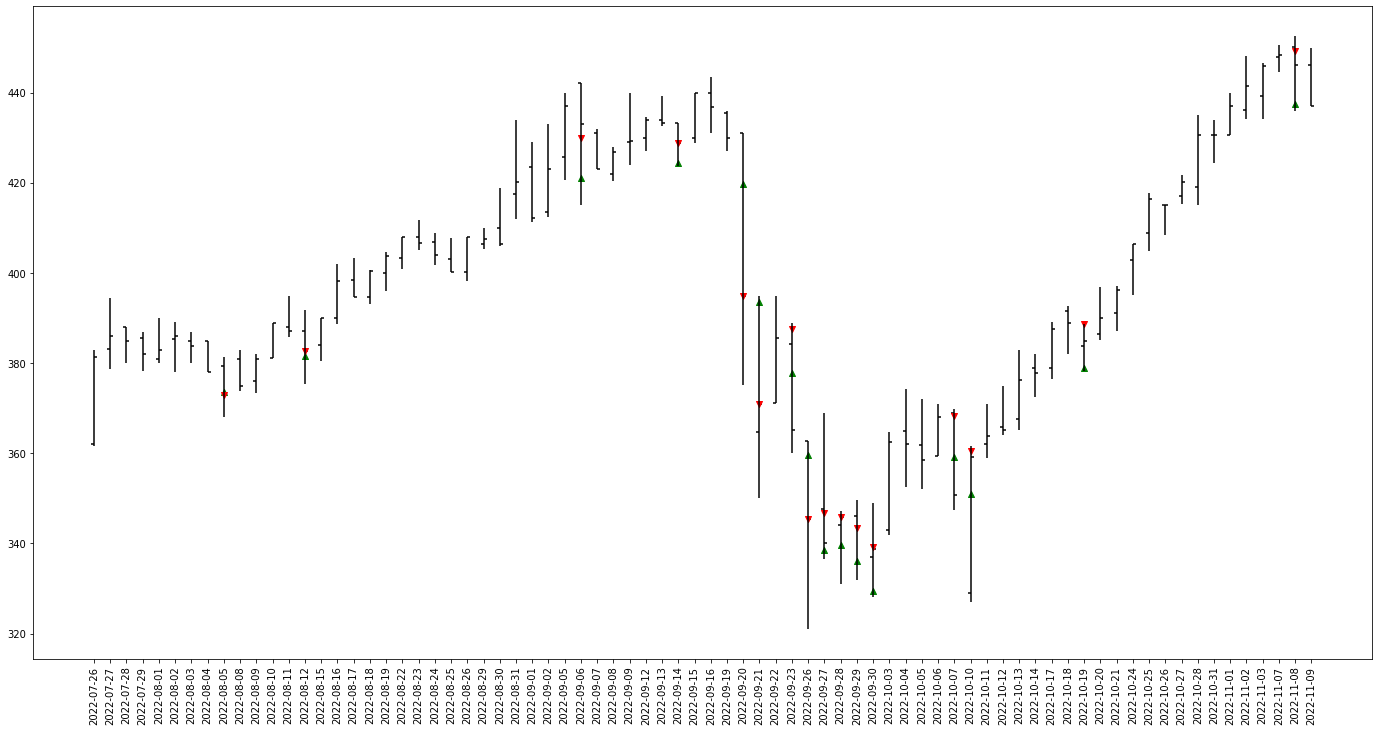

In [ ]:
# Визуализируем наши покупки и продажи
plt.figure(figsize=(24, 12))
dtstr = make_finplot(df_y[1:])
plt.scatter(dtstr[price_op > 0], price_op[price_op > 0], marker='^', color='g')
plt.scatter(dtstr[price_cp > 0], price_cp[price_cp > 0], marker='v', color='r')
plt.show()